# 1. Creación de Escenarios y Particiones por Consulta Clínica para cada día del Set de Pruebas.

## 1.1 Importación de Librerías y Carga del Set de Pruebas heredado de la Fase 1 - Predicción de No Shows.

In [1]:
import pandas as pd
from datetime import datetime
import random

from openpyxl import Workbook
from openpyxl.styles import Alignment
from openpyxl.utils.dataframe import dataframe_to_rows

In [2]:
# Ruta del archivo CSV con los datos del Set de Pruebas
file_path = "./test_set_P1-ALL-ADASYN con Prob_No_Show_TabNet.xlsx"

# Leer el archivo EXCEL
full_set = pd.read_excel(file_path)

# Nos quedamos con el contenido que necesitamos: 'PatientId', 'ScheduledDay', 'AppointmentDay', 'NoShow', 'Prob_NoShow'
app_set = full_set[['PatientId', 'ScheduledDay', 'AppointmentDay', 'NoShow', 'Prob_NoShow']]

# Convertimos 'ScheduledDay' y 'AppointmentDay' a datetime
pd.options.mode.copy_on_write = True
app_set['ScheduledDay'] = pd.to_datetime(app_set['ScheduledDay'])
app_set['AppointmentDay'] = pd.to_datetime(app_set['AppointmentDay'])

# Mostrar el contenido del DataFrame
app_set

PatientId        ScheduledDay AppointmentDay  NoShow  Prob_NoShow
0       29151176571548 2016-03-07 07:54:22     2016-05-30    True     0.612299
1        5545211593544 2016-04-01 09:10:54     2016-05-30    True     0.633393
2       28438412943986 2016-04-01 09:14:31     2016-05-30    True     0.485438
3        8338993186939 2016-04-01 14:20:09     2016-05-30    True     0.717672
4        8965113984137 2016-04-05 15:38:53     2016-05-30    True     0.641244
...                ...                 ...            ...     ...          ...
22092  729255235141745 2016-06-08 19:32:25     2016-06-08   False     0.030953
22093  947614361749238 2016-06-08 19:32:56     2016-06-08   False     0.125537
22094     356247857784 2016-06-08 19:33:23     2016-06-08   False     0.045798
22095     234131759175 2016-06-08 19:58:52     2016-06-08   False     0.045798
22096    5237164264312 2016-06-08 20:07:23     2016-06-08   False     0.066827

[22097 rows x 5 columns]

In [3]:
app_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22097 entries, 0 to 22096
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   PatientId       22097 non-null  int64         
 1   ScheduledDay    22097 non-null  datetime64[ns]
 2   AppointmentDay  22097 non-null  datetime64[ns]
 3   NoShow          22097 non-null  bool          
 4   Prob_NoShow     22097 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1)
memory usage: 712.2 KB


## 1.2 Revisión de Set de Datos.

Revisamos las citas por 'AppointmentDay', verificando que tengamos datos correctos para cada fecha.

Agrupamos los datos por 'AppointmentDay', revisamos proporción de NoShows, y guardamos dichos subconjuntos.

In [4]:
# Group the DataFrame by 'AppointmentDay'
grouped_data = app_set.groupby('AppointmentDay')

# Create a dictionary to store the smaller datasets
test_datasets = {}

# Iterate over each group and store the corresponding dataset in the dictionary
for day, group in grouped_data:
    test_datasets[day] = group

# Access, review and store the datasets for specific days
print('\nSets de Datos completos:')
for date_key, miniset in test_datasets.items():
    print(f"\tEl set para el {date_key.date()} tiene {miniset.shape[0]} citas, \
con un porcentaje de NoShows del {miniset['NoShow'].mean():.2%}.")
    if miniset.shape[0] < 200 or miniset['NoShow'].mean() > 0.25:
        print(f"\t\t\033[1mDescartamos los datos del {date_key.date()} por \
insuficiencia de datos y/o por haber excesivos No Show.\033[0m")

print("\n\033[1mREHACEMOS TODO EL PROCESO DESCARTANDO LOS DATOS DEL 30 Y 31 DE MAYO.\033[0m\n")


Sets de Datos completos:
	El set para el 2016-05-30 tiene 60 citas, con un porcentaje de NoShows del 100.00%.
		Descartamos los datos del 2016-05-30 por insuficiencia de datos y/o por haber excesivos No Show.
	El set para el 2016-05-31 tiene 765 citas, con un porcentaje de NoShows del 66.80%.
		Descartamos los datos del 2016-05-31 por insuficiencia de datos y/o por haber excesivos No Show.
	El set para el 2016-06-01 tiene 3061 citas, con un porcentaje de NoShows del 18.75%.
	El set para el 2016-06-02 tiene 3248 citas, con un porcentaje de NoShows del 18.29%.
	El set para el 2016-06-03 tiene 3163 citas, con un porcentaje de NoShows del 19.60%.
	El set para el 2016-06-06 tiene 3802 citas, con un porcentaje de NoShows del 18.73%.
	El set para el 2016-06-07 tiene 3884 citas, con un porcentaje de NoShows del 17.64%.
	El set para el 2016-06-08 tiene 4114 citas, con un porcentaje de NoShows del 17.14%.

REHACEMOS TODO EL PROCESO DESCARTANDO LOS DATOS DEL 30 Y 31 DE MAYO.



In [5]:
# Quitamos las citas del 30 y 31 de mayo.
new_app_set = app_set[~app_set['AppointmentDay'].dt.strftime('%Y-%m-%d').isin(['2016-05-30', '2016-05-31'])]

print(new_app_set[new_app_set['AppointmentDay'] == datetime(2016, 5, 30)])
print(new_app_set[new_app_set['AppointmentDay'] == datetime(2016, 5, 31)])

Empty DataFrame
Columns: [PatientId, ScheduledDay, AppointmentDay, NoShow, Prob_NoShow]
Index: []
Empty DataFrame
Columns: [PatientId, ScheduledDay, AppointmentDay, NoShow, Prob_NoShow]
Index: []


In [6]:
new_app_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21272 entries, 825 to 22096
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   PatientId       21272 non-null  int64         
 1   ScheduledDay    21272 non-null  datetime64[ns]
 2   AppointmentDay  21272 non-null  datetime64[ns]
 3   NoShow          21272 non-null  bool          
 4   Prob_NoShow     21272 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1)
memory usage: 851.7 KB


In [7]:
# Group the DataFrame by 'AppointmentDay'
grouped_data = new_app_set.groupby('AppointmentDay')

# Create a dictionary to store the smaller datasets
new_datasets = {}

# Iterate over each group and store the corresponding dataset in the dictionary
for day, group in grouped_data:
    new_datasets[day] = group

# Access, review and store the datasets for specific days
print('\nSets de Prueba completos:')
for date_key, miniset in new_datasets.items():
    print(f"\tEl set para el {date_key.date()} tiene {miniset.shape[0]} citas, \
con un porcentaje de NoShows del {miniset['NoShow'].mean():.2%}.")
    if miniset.shape[0] < 200 or miniset['NoShow'].mean() > 0.25:
        print(f"\t\t\033[1mDescartamos los datos del {date_key.date()} por \
insuficiencia de datos y/o por haber excesivos No Show.\033[0m")


Sets de Prueba completos:
	El set para el 2016-06-01 tiene 3061 citas, con un porcentaje de NoShows del 18.75%.
	El set para el 2016-06-02 tiene 3248 citas, con un porcentaje de NoShows del 18.29%.
	El set para el 2016-06-03 tiene 3163 citas, con un porcentaje de NoShows del 19.60%.
	El set para el 2016-06-06 tiene 3802 citas, con un porcentaje de NoShows del 18.73%.
	El set para el 2016-06-07 tiene 3884 citas, con un porcentaje de NoShows del 17.64%.
	El set para el 2016-06-08 tiene 4114 citas, con un porcentaje de NoShows del 17.14%.


# 2. Cálculo de Costes

## 2.1 Regla de Asignación de Cita
### **Por Probabilidades de Asistencia**

Al primer paciente que pide una cita para un determinado día se le asigna al primer slot de la primera consulta, y se guarda también su probabilidad de asistencia.

Cuando un nuevo paciente solicita cita para el mismo día, se revisa slot por slot, y se le coloca en el primer slot donde la suma de las probabilidades de asistencia de todos los pacientes asignados a dicho slot, incluido este último, sea menor de un porcentaje determinado = "liston_ProbShow".

Si no "cabe" en ningún slot, se "abre" otra consulta.

In [8]:
def calculo_liston_ProbShow(x_values: list, y_values: list, x: int) -> float:
    '''
    Calcula la coordenada "y" de una función polinómica para una coordenada "x" dada,
    usando cualquier número de puntos (Interpolación polinómica de Lagrange)
    Parámetros:
        x_values: Lista de coordenadas "x" de los puntos conocidos por donde debe pasar
                    la función polinómica.
        y_values: Lista de coordenadas "y" de los 3 puntos conocidos por donde debe pasar
                    la función polinómica.
        x: La coordenada para la cual se desea calcular la coordenada "y" de la
            función polinómica de Lagrange.
    Retorna:
        float: La coordenada "y" correspondiente en la función polinómica definida
                por un número indeterminado de puntos.
    '''
    grado_funcion = len(x_values)
    y = 0.0

    for i in range(grado_funcion):
        # Calcula el polinomio L_i(x)
        L_i = 1
        for j in range(grado_funcion):
            if i != j:
                L_i *= (x - x_values[j]) / (x_values[i] - x_values[j])
        
        # Añade el término correspondiente a y_i
        y += y_values[i] * L_i

    return y

def asignar_paciente_ProbShow(agenda_medica: dict,
                                paciente_id: str,
                                fecha: datetime.date,
                                x_values: list,
                                y_values:list,
                                prob_show: float) -> dict:
    '''
    Asigna un paciente a un slot de consulta en una agenda médica según la probabilidad de asistencia (prob_show).
    
    Parámetros:
    -----------
    agenda_medica : dict = Diccionario que representa la agenda médica. La estructura esperada es:
        {
            fecha: {
                consulta_key: {
                    slot_key: [(paciente_id, prob_show), ...],
                    ...
                },
                ...
            },
            ...
        }
    paciente_id : str = Identificador único del paciente.
    fecha : datetime.date = Fecha en la que se desea asignar el paciente.
    prob_show : float = Probabilidad de que el paciente se presente a la cita (0.0 <= prob_show <= 1.0).
    
    Retorno:
    --------
    dict = La agenda médica actualizada con el paciente asignado a un slot apropiado.

    Detalles:
    ---------
    - La función intenta asignar el paciente a un slot existente en la consulta en la fecha dada.
    - Cada slot puede tener un máximo de 3 pacientes.
    - La asignación se basa en un umbral calculado de probabilidad de asistencia (`liston_ProbShow`), que varía según el slot.
    - Si no hay slots disponibles que cumplan con las condiciones, se crea un nuevo slot en una consulta existente.
    - Si todas las consultas tienen 24 slots, se crea una nueva consulta con un nuevo slot para el paciente.
    '''

    # Diferenciamos x_values de la mañana y de la tarde
    x_values_mañana = x_values
    x_values_tarde = [x_value + 12 for x_value in x_values]

    paciente_sin_asignar = True

    while paciente_sin_asignar:
        asignado = False

        # Iteramos sobre consultas y slots para asignar el paciente
        for consulta_key, slots in agenda_medica[fecha].items():
            for slot_idx, (slot_key, pacientes) in enumerate(slots.items(), start=1):
                suma_prob_show = sum(paciente[1] for paciente in pacientes)
                
                # Calculamos el listón de ProbShow que tenemos fijado como condición de contorno
                # print(f'Slot_idx = {slot_idx}')
                if slot_idx in range(1, 13):
                    liston_ProbShow = calculo_liston_ProbShow(x_values_mañana, y_values, slot_idx)
                else:
                    liston_ProbShow = calculo_liston_ProbShow(x_values_tarde, y_values, slot_idx)
                # print(f'Liston_ProbShow = {liston_ProbShow}')

                # Verificamos si el paciente puede ser asignado al slot
                if len(pacientes) < 3 and suma_prob_show + prob_show < liston_ProbShow:
                    slot = agenda_medica[fecha][consulta_key][slot_key]
                    slot.append((paciente_id, prob_show))
                    ### print(f'\t\t{fecha} {consulta_key} {slot_key}:\
                    ### {agenda_medica[fecha][consulta_key][slot_key]}\n')
                    asignado = True
                    break  # Salimos del bucle de slots

            if asignado:
                break  # Salimos del bucle de consultas

        if asignado:
            paciente_sin_asignar = False  # Rompemos el while_condition
        else:
            # Si no se pudo asignar el paciente a ningún slot existente,
            # abrimos un nuevo slot en una consulta existente
            for consulta_key, slots in agenda_medica[fecha].items():
                if len(slots) < 24:
                    num_slot = len(slots) + 1
                    slot_key = f'slot_{num_slot:02d}'
                    agenda_medica[fecha][consulta_key][slot_key] = []
                    ### print(f'\tAbrimos {slot_key} en {consulta_key} para el {fecha}.\n')
                    slot = agenda_medica[fecha][consulta_key][slot_key]
                    slot.append((paciente_id, prob_show))
                    ### print(f'\t\t{fecha} {consulta_key} {slot_key}:\
                    ### {agenda_medica[fecha][consulta_key][slot_key]}\n')
                    paciente_sin_asignar = False  # Rompemos el while_condition
                    break  # Salimos del bucle de consultas

            if paciente_sin_asignar:
                # Si no hemos podido asignar (porque todas las consultas están a tope),
                # abre una nueva consulta y un nuevo slot
                num_consulta = len(agenda_medica[fecha]) + 1
                consulta_key = f'consulta_{num_consulta:03d}'
                agenda_medica[fecha][consulta_key] = {}
                ### print(f'\t\tAbrimos {consulta_key} para el {fecha}.')
                agenda_medica[fecha][consulta_key]['slot_01'] = []
                ### print(f'\t\tAbrimos slot_01 en {consulta_key} para el {fecha}.')
                slot_01 = agenda_medica[fecha][consulta_key]['slot_01']
                slot_01.append((paciente_id, prob_show))
                ### print(f'\t\t\t{fecha} {consulta_key} slot_01:\
                ### {agenda_medica[fecha][consulta_key]["slot_01"]}\n')
                paciente_sin_asignar = False  # Rompemos el while_condition

    return agenda_medica

Ordenamos el Set de Validación por fecha de solicitud de cita para aplicar las Reglas de Asignación con una Secuencia de First Call First In.

In [9]:
final_app_set = new_app_set.sort_values('ScheduledDay')

Definimos los puntos de paso de las función polinómica que define el Liston_ProbShow, para diferentes escenarios.

In [10]:
x_values_linear = [1, 12]
y_values_linear1 = [
    [0.90, 0.10], [0.90, 0.15], [0.90, 0.20]
]
y_values_linear2 = [
    [0.95, 0.10], [0.95, 0.15], [0.95, 0.20]
]
y_values_linear3 = [
    [1.00, 0.10], [1.00, 0.15], [1.00, 0.20]
]

x_values_cuadratic = [1, 6.5, 12]
y_values_cuadratic1 = [
    [0.85, 0.45, 0.30], [0.85, 0.50, 0.30], [0.85, 0.55, 0.30], [0.85, 0.60, 0.30]
]
y_values_cuadratic2 = [
    [0.90, 0.45, 0.20], [0.90, 0.50, 0.20], [0.90, 0.55, 0.20], [0.90, 0.60, 0.20]
]
y_values_cuadratic3 = [
    [0.90, 0.40, 0.25], [0.90, 0.45, 0.25], [0.90, 0.50, 0.25], [0.90, 0.55, 0.25]
]
y_values_cuadratic4 = [
    [1.00, 0.30, 0.15], [1.00, 0.35, 0.15], [1.00, 0.30, 0.20], [1.00, 0.35, 0.20]
]
y_values_cuadratic5 = [
    [1.05, 0.30, 0.15], [1.05, 0.35, 0.15], [1.05, 0.40, 0.15], [1.05, 0.45, 0.15]
]
y_values_cuadratic6 = [
    [1.10, 0.25, 0.15], [1.10, 0.30, 0.15], [1.10, 0.35, 0.15], [1.10, 0.40, 0.15]
]

In [11]:
agendas_medicas_ProbShow = {}

In [12]:
for y_values in y_values_linear1:
    x_values = x_values_linear
    nombre_agenda = f'ProbShow_{str(y_values[0])}_{str(y_values[1])}'
    agendas_medicas_ProbShow[nombre_agenda] = {}
    print(f'Abrimos Agenda Médica: {nombre_agenda}.')

    for cita in final_app_set.itertuples(index=True, name='Pandas'):
        fecha_cita = cita.AppointmentDay.date()
        prob_show = 1 - cita.Prob_NoShow

        if fecha_cita in agendas_medicas_ProbShow[nombre_agenda].keys():
            agendas_medicas_ProbShow[nombre_agenda] = asignar_paciente_ProbShow(
                agendas_medicas_ProbShow[nombre_agenda],
                cita.PatientId,
                fecha_cita,
                x_values,
                y_values,
                prob_show
            )
        else:
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita] = {}
            ### print(f'\tAbrimos fecha en la agenda {nombre_agenda} para el {fecha_cita}.')
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001'] = {}
            ### print(f'\t\tAbrimos consulta_001 para el {fecha_cita}.')
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001']['slot_01'] = []
            ### print(f'\t\tAbrimos slot_01 en consulta_001 para el {fecha_cita}.')
            slot_01 = agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001']['slot_01']
            slot_01.append((cita.PatientId, prob_show))
            ### print(f'\t\t\t{fecha_cita} consulta_001 slot_01: \
            ### {agendas_medicas_ProbShow[nombre_agenda][fecha_cita]["consulta_001"]["slot_01"]}\n')

Abrimos Agenda Médica: ProbShow_0.9_0.1.
Abrimos Agenda Médica: ProbShow_0.9_0.15.
Abrimos Agenda Médica: ProbShow_0.9_0.2.


In [13]:
for y_values in y_values_linear2:
    x_values = x_values_linear
    nombre_agenda = f'ProbShow_{str(y_values[0])}_{str(y_values[1])}'
    agendas_medicas_ProbShow[nombre_agenda] = {}
    print(f'Abrimos Agenda Médica: {nombre_agenda}.')

    for cita in final_app_set.itertuples(index=True, name='Pandas'):
        fecha_cita = cita.AppointmentDay.date()
        prob_show = 1 - cita.Prob_NoShow

        if fecha_cita in agendas_medicas_ProbShow[nombre_agenda].keys():
            agendas_medicas_ProbShow[nombre_agenda] = asignar_paciente_ProbShow(
                agendas_medicas_ProbShow[nombre_agenda],
                cita.PatientId,
                fecha_cita,
                x_values,
                y_values,
                prob_show
            )
        else:
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita] = {}
            ### print(f'\tAbrimos fecha en la agenda {nombre_agenda} para el {fecha_cita}.')
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001'] = {}
            ### print(f'\t\tAbrimos consulta_001 para el {fecha_cita}.')
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001']['slot_01'] = []
            ### print(f'\t\tAbrimos slot_01 en consulta_001 para el {fecha_cita}.')
            slot_01 = agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001']['slot_01']
            slot_01.append((cita.PatientId, prob_show))
            ### print(f'\t\t\t{fecha_cita} consulta_001 slot_01: \
            ### {agendas_medicas_ProbShow[nombre_agenda][fecha_cita]["consulta_001"]["slot_01"]}\n')

Abrimos Agenda Médica: ProbShow_0.95_0.1.
Abrimos Agenda Médica: ProbShow_0.95_0.15.
Abrimos Agenda Médica: ProbShow_0.95_0.2.


In [14]:
for y_values in y_values_linear3:
    x_values = x_values_linear
    nombre_agenda = f'ProbShow_{str(y_values[0])}_{str(y_values[1])}'
    agendas_medicas_ProbShow[nombre_agenda] = {}
    print(f'Abrimos Agenda Médica: {nombre_agenda}.')

    for cita in final_app_set.itertuples(index=True, name='Pandas'):
        fecha_cita = cita.AppointmentDay.date()
        prob_show = 1 - cita.Prob_NoShow

        if fecha_cita in agendas_medicas_ProbShow[nombre_agenda].keys():
            agendas_medicas_ProbShow[nombre_agenda] = asignar_paciente_ProbShow(
                agendas_medicas_ProbShow[nombre_agenda],
                cita.PatientId,
                fecha_cita,
                x_values,
                y_values,
                prob_show
            )
        else:
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita] = {}
            ### print(f'\tAbrimos fecha en la agenda {nombre_agenda} para el {fecha_cita}.')
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001'] = {}
            ### print(f'\t\tAbrimos consulta_001 para el {fecha_cita}.')
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001']['slot_01'] = []
            ### print(f'\t\tAbrimos slot_01 en consulta_001 para el {fecha_cita}.')
            slot_01 = agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001']['slot_01']
            slot_01.append((cita.PatientId, prob_show))
            ### print(f'\t\t\t{fecha_cita} consulta_001 slot_01: \
            ### {agendas_medicas_ProbShow[nombre_agenda][fecha_cita]["consulta_001"]["slot_01"]}\n')

Abrimos Agenda Médica: ProbShow_1.0_0.1.
Abrimos Agenda Médica: ProbShow_1.0_0.15.
Abrimos Agenda Médica: ProbShow_1.0_0.2.


In [12]:
for y_values in y_values_cuadratic1:
    x_values = x_values_cuadratic
    nombre_agenda = f'ProbShow_{str(y_values[0])}_{str(y_values[1])}_{str(y_values[2])}'
    agendas_medicas_ProbShow[nombre_agenda] = {}
    print(f'Abrimos Agenda Médica: {nombre_agenda}.')

    for cita in final_app_set.itertuples(index=True, name='Pandas'):
        fecha_cita = cita.AppointmentDay.date()
        prob_show = 1 - cita.Prob_NoShow

        if fecha_cita in agendas_medicas_ProbShow[nombre_agenda].keys():
            agendas_medicas_ProbShow[nombre_agenda] = asignar_paciente_ProbShow(
                agendas_medicas_ProbShow[nombre_agenda],
                cita.PatientId,
                fecha_cita,
                x_values,
                y_values,
                prob_show
            )
        else:
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita] = {}
            ### print(f'\tAbrimos fecha en la agenda {nombre_agenda} para el {fecha_cita}.')
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001'] = {}
            ### print(f'\t\tAbrimos consulta_001 para el {fecha_cita}.')
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001']['slot_01'] = []
            ### print(f'\t\tAbrimos slot_01 en consulta_001 para el {fecha_cita}.')
            slot_01 = agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001']['slot_01']
            slot_01.append((cita.PatientId, prob_show))
            ### print(f'\t\t\t{fecha_cita} consulta_001 slot_01: \
            ### {agendas_medicas_ProbShow[nombre_agenda][fecha_cita]["consulta_001"]["slot_01"]}\n')

Abrimos Agenda Médica: ProbShow_0.85_0.45_0.3.
Abrimos Agenda Médica: ProbShow_0.85_0.5_0.3.
Abrimos Agenda Médica: ProbShow_0.85_0.55_0.3.
Abrimos Agenda Médica: ProbShow_0.85_0.6_0.3.


In [13]:
for y_values in y_values_cuadratic2:
    x_values = x_values_cuadratic
    nombre_agenda = f'ProbShow_{str(y_values[0])}_{str(y_values[1])}_{str(y_values[2])}'
    agendas_medicas_ProbShow[nombre_agenda] = {}
    print(f'Abrimos Agenda Médica: {nombre_agenda}.')

    for cita in final_app_set.itertuples(index=True, name='Pandas'):
        fecha_cita = cita.AppointmentDay.date()
        prob_show = 1 - cita.Prob_NoShow

        if fecha_cita in agendas_medicas_ProbShow[nombre_agenda].keys():
            agendas_medicas_ProbShow[nombre_agenda] = asignar_paciente_ProbShow(
                agendas_medicas_ProbShow[nombre_agenda],
                cita.PatientId,
                fecha_cita,
                x_values,
                y_values,
                prob_show
            )
        else:
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita] = {}
            ### print(f'\tAbrimos fecha en la agenda {nombre_agenda} para el {fecha_cita}.')
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001'] = {}
            ### print(f'\t\tAbrimos consulta_001 para el {fecha_cita}.')
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001']['slot_01'] = []
            ### print(f'\t\tAbrimos slot_01 en consulta_001 para el {fecha_cita}.')
            slot_01 = agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001']['slot_01']
            slot_01.append((cita.PatientId, prob_show))
            ### print(f'\t\t\t{fecha_cita} consulta_001 slot_01: \
            ### {agendas_medicas_ProbShow[nombre_agenda][fecha_cita]["consulta_001"]["slot_01"]}\n')

Abrimos Agenda Médica: ProbShow_0.9_0.45_0.2.
Abrimos Agenda Médica: ProbShow_0.9_0.5_0.2.
Abrimos Agenda Médica: ProbShow_0.9_0.55_0.2.
Abrimos Agenda Médica: ProbShow_0.9_0.6_0.2.


In [14]:
for y_values in y_values_cuadratic3:
    x_values = x_values_cuadratic
    nombre_agenda = f'ProbShow_{str(y_values[0])}_{str(y_values[1])}_{str(y_values[2])}'
    agendas_medicas_ProbShow[nombre_agenda] = {}
    print(f'Abrimos Agenda Médica: {nombre_agenda}.')

    for cita in final_app_set.itertuples(index=True, name='Pandas'):
        fecha_cita = cita.AppointmentDay.date()
        prob_show = 1 - cita.Prob_NoShow

        if fecha_cita in agendas_medicas_ProbShow[nombre_agenda].keys():
            agendas_medicas_ProbShow[nombre_agenda] = asignar_paciente_ProbShow(
                agendas_medicas_ProbShow[nombre_agenda],
                cita.PatientId,
                fecha_cita,
                x_values,
                y_values,
                prob_show
            )
        else:
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita] = {}
            ### print(f'\tAbrimos fecha en la agenda {nombre_agenda} para el {fecha_cita}.')
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001'] = {}
            ### print(f'\t\tAbrimos consulta_001 para el {fecha_cita}.')
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001']['slot_01'] = []
            ### print(f'\t\tAbrimos slot_01 en consulta_001 para el {fecha_cita}.')
            slot_01 = agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001']['slot_01']
            slot_01.append((cita.PatientId, prob_show))
            ### print(f'\t\t\t{fecha_cita} consulta_001 slot_01: \
            ### {agendas_medicas_ProbShow[nombre_agenda][fecha_cita]["consulta_001"]["slot_01"]}\n')

Abrimos Agenda Médica: ProbShow_0.9_0.4_0.25.
Abrimos Agenda Médica: ProbShow_0.9_0.45_0.25.
Abrimos Agenda Médica: ProbShow_0.9_0.5_0.25.
Abrimos Agenda Médica: ProbShow_0.9_0.55_0.25.


In [12]:
for y_values in y_values_cuadratic4:
    x_values = x_values_cuadratic
    nombre_agenda = f'ProbShow_{str(y_values[0])}_{str(y_values[1])}_{str(y_values[2])}'
    agendas_medicas_ProbShow[nombre_agenda] = {}
    print(f'Abrimos Agenda Médica: {nombre_agenda}.')

    for cita in final_app_set.itertuples(index=True, name='Pandas'):
        fecha_cita = cita.AppointmentDay.date()
        prob_show = 1 - cita.Prob_NoShow

        if fecha_cita in agendas_medicas_ProbShow[nombre_agenda].keys():
            agendas_medicas_ProbShow[nombre_agenda] = asignar_paciente_ProbShow(
                agendas_medicas_ProbShow[nombre_agenda],
                cita.PatientId,
                fecha_cita,
                x_values,
                y_values,
                prob_show
            )
        else:
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita] = {}
#             print(f'\tAbrimos fecha en la agenda {nombre_agenda} para el {fecha_cita}.')
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001'] = {}
#             print(f'\t\tAbrimos consulta_001 para el {fecha_cita}.')
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001']['slot_01'] = []
#             print(f'\t\tAbrimos slot_01 en consulta_001 para el {fecha_cita}.')
            slot_01 = agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001']['slot_01']
            slot_01.append((cita.PatientId, prob_show))
#             print(f'\t\t\t{fecha_cita} consulta_001 slot_01: \
# {agendas_medicas_ProbShow[nombre_agenda][fecha_cita]["consulta_001"]["slot_01"]}\n')

Abrimos Agenda Médica: ProbShow_1.0_0.3_0.15.
Abrimos Agenda Médica: ProbShow_1.0_0.35_0.15.
Abrimos Agenda Médica: ProbShow_1.0_0.3_0.2.
Abrimos Agenda Médica: ProbShow_1.0_0.35_0.2.


In [13]:
for y_values in y_values_cuadratic5:
    x_values = x_values_cuadratic
    nombre_agenda = f'ProbShow_{str(y_values[0])}_{str(y_values[1])}_{str(y_values[2])}'
    agendas_medicas_ProbShow[nombre_agenda] = {}
    print(f'Abrimos Agenda Médica: {nombre_agenda}.')

    for cita in final_app_set.itertuples(index=True, name='Pandas'):
        fecha_cita = cita.AppointmentDay.date()
        prob_show = 1 - cita.Prob_NoShow

        if fecha_cita in agendas_medicas_ProbShow[nombre_agenda].keys():
            agendas_medicas_ProbShow[nombre_agenda] = asignar_paciente_ProbShow(
                agendas_medicas_ProbShow[nombre_agenda],
                cita.PatientId,
                fecha_cita,
                x_values,
                y_values,
                prob_show
            )
        else:
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita] = {}
            ### print(f'\tAbrimos fecha en la agenda {nombre_agenda} para el {fecha_cita}.')
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001'] = {}
            ### print(f'\t\tAbrimos consulta_001 para el {fecha_cita}.')
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001']['slot_01'] = []
            ### print(f'\t\tAbrimos slot_01 en consulta_001 para el {fecha_cita}.')
            slot_01 = agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001']['slot_01']
            slot_01.append((cita.PatientId, prob_show))
            ### print(f'\t\t\t{fecha_cita} consulta_001 slot_01: \
            ### {agendas_medicas_ProbShow[nombre_agenda][fecha_cita]["consulta_001"]["slot_01"]}\n')

Abrimos Agenda Médica: ProbShow_1.05_0.3_0.15.
Abrimos Agenda Médica: ProbShow_1.05_0.35_0.15.
Abrimos Agenda Médica: ProbShow_1.05_0.4_0.15.
Abrimos Agenda Médica: ProbShow_1.05_0.45_0.15.


In [14]:
for y_values in y_values_cuadratic6:
    x_values = x_values_cuadratic
    nombre_agenda = f'ProbShow_{str(y_values[0])}_{str(y_values[1])}_{str(y_values[2])}'
    agendas_medicas_ProbShow[nombre_agenda] = {}
    print(f'Abrimos Agenda Médica: {nombre_agenda}.')

    for cita in final_app_set.itertuples(index=True, name='Pandas'):
        fecha_cita = cita.AppointmentDay.date()
        prob_show = 1 - cita.Prob_NoShow

        if fecha_cita in agendas_medicas_ProbShow[nombre_agenda].keys():
            agendas_medicas_ProbShow[nombre_agenda] = asignar_paciente_ProbShow(
                agendas_medicas_ProbShow[nombre_agenda],
                cita.PatientId,
                fecha_cita,
                x_values,
                y_values,
                prob_show
            )
        else:
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita] = {}
            ### print(f'\tAbrimos fecha en la agenda {nombre_agenda} para el {fecha_cita}.')
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001'] = {}
            ### print(f'\t\tAbrimos consulta_001 para el {fecha_cita}.')
            agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001']['slot_01'] = []
            ### print(f'\t\tAbrimos slot_01 en consulta_001 para el {fecha_cita}.')
            slot_01 = agendas_medicas_ProbShow[nombre_agenda][fecha_cita]['consulta_001']['slot_01']
            slot_01.append((cita.PatientId, prob_show))
            ### print(f'\t\t\t{fecha_cita} consulta_001 slot_01: \
            ### {agendas_medicas_ProbShow[nombre_agenda][fecha_cita]["consulta_001"]["slot_01"]}\n')

Abrimos Agenda Médica: ProbShow_1.1_0.25_0.15.
Abrimos Agenda Médica: ProbShow_1.1_0.3_0.15.
Abrimos Agenda Médica: ProbShow_1.1_0.35_0.15.
Abrimos Agenda Médica: ProbShow_1.1_0.4_0.15.


In [15]:
# Convertir los diccionarios agenda medica en unas listas de diccionarios aplanados
agendas_medicas_ProbShow_aplanadas = {}
dfs_agendas_medicas = {}
for agenda_key, agenda in agendas_medicas_ProbShow.items():
    nombre_agenda = f'agenda_medica_{agenda_key}'
    agendas_medicas_ProbShow_aplanadas[nombre_agenda] = []
    for fecha_key, consultas in agenda.items():
        for consulta_key, slots in consultas.items():
            for slot_key, pacientes in slots.items():
                for paciente_id, prob_show in pacientes:
                    agendas_medicas_ProbShow_aplanadas[nombre_agenda].append({
                        'Fecha': fecha_key,
                        'Consulta': consulta_key,
                        'Slot': slot_key,
                        'Paciente_ID': paciente_id,
                        'Probabilidad_Show': prob_show
                    })

    # Crear un DataFrame por Agenda Médica a partir de la lista de diccionarios
    dfs_agendas_medicas[nombre_agenda] = pd.DataFrame(agendas_medicas_ProbShow_aplanadas[nombre_agenda])

    # Ordenar cada Agenda Médica por Fecha, Número de Consulta y Número de Slot
    dfs_agendas_medicas[nombre_agenda] = dfs_agendas_medicas[nombre_agenda].sort_values(
        by=['Fecha', 'Consulta', 'Slot'],
        ascending=[True, True, True]
    )

    # Guardar cada Agenda Médica en archivo Excel
    file = f'{nombre_agenda}.xlsx'
    dfs_agendas_medicas[nombre_agenda].to_excel(file, index=False)
    print(f'Se ha guardado la Agenda Médica en el archivo "{file}".')

Se ha guardado la Agenda Médica en el archivo "agenda_medica_ProbShow_1.0_0.3_0.15.xlsx".
Se ha guardado la Agenda Médica en el archivo "agenda_medica_ProbShow_1.0_0.35_0.15.xlsx".
Se ha guardado la Agenda Médica en el archivo "agenda_medica_ProbShow_1.0_0.3_0.2.xlsx".
Se ha guardado la Agenda Médica en el archivo "agenda_medica_ProbShow_1.0_0.35_0.2.xlsx".
Se ha guardado la Agenda Médica en el archivo "agenda_medica_ProbShow_1.05_0.3_0.15.xlsx".
Se ha guardado la Agenda Médica en el archivo "agenda_medica_ProbShow_1.05_0.35_0.15.xlsx".
Se ha guardado la Agenda Médica en el archivo "agenda_medica_ProbShow_1.05_0.4_0.15.xlsx".
Se ha guardado la Agenda Médica en el archivo "agenda_medica_ProbShow_1.05_0.45_0.15.xlsx".
Se ha guardado la Agenda Médica en el archivo "agenda_medica_ProbShow_1.1_0.25_0.15.xlsx".
Se ha guardado la Agenda Médica en el archivo "agenda_medica_ProbShow_1.1_0.3_0.15.xlsx".
Se ha guardado la Agenda Médica en el archivo "agenda_medica_ProbShow_1.1_0.35_0.15.xlsx".
Se

In [16]:
consultas_por_fecha = {}
dfs_consultas_por_fecha = {}
pacientes_por_consulta = {}
dfs_pacientes_por_consulta = {}

for agenda_key, agenda in agendas_medicas_ProbShow.items():
    # Revisamos número de consultas por Fecha
    consultas_por_fecha[agenda_key] = []
    for fecha_key in agenda.keys():
        consultas_por_fecha[agenda_key].append({
            'Fecha': fecha_key,
            'Número Consultas': len(agenda[fecha_key])
        })
    dfs_consultas_por_fecha[agenda_key] = pd.DataFrame(consultas_por_fecha[agenda_key])

    # Revisamos número de pacientes por Consulta
    pacientes_por_consulta[agenda_key] = []
    for fecha_key, consultas in agenda.items():
        for consulta_key, slots in consultas.items():
            num_pacientes_por_consulta = 0
            for pacientes in slots.values(): 
                num_pacientes_por_consulta += len(pacientes)
            pacientes_por_consulta[agenda_key].append({
                'Fecha': fecha_key,
                'Consulta': consulta_key,
                'Número Pacientes': num_pacientes_por_consulta
            })
    dfs_pacientes_por_consulta[agenda_key] = pd.DataFrame(pacientes_por_consulta[agenda_key])
    dfs_pacientes_por_consulta[agenda_key] = dfs_pacientes_por_consulta[agenda_key].sort_values(
        by=['Fecha','Consulta'],
        ascending=[True, True]
    )

In [17]:
dfs_medias = {}
dfs_consultas_por_fecha_con_media_pacientes = {}

for agenda_key in dfs_consultas_por_fecha.keys():
    # Calculamos la media de pacientes por consulta para cada fecha
    df_pacientes = dfs_pacientes_por_consulta[agenda_key]
    df_media = df_pacientes.groupby('Fecha')['Número Pacientes'].mean().reset_index()
    df_media.columns = ['Fecha', 'Media Pacientes por Consulta']

    # Guardamos el resultado en dfs_medias
    dfs_medias[agenda_key] = df_media

    # Añadimos los resultados al DataFrame df_consultas_por_fecha
    df_merged = pd.merge(
        dfs_consultas_por_fecha[agenda_key],
        df_media[['Fecha', 'Media Pacientes por Consulta']],
        on='Fecha',
        how='left'
    )

    # Guardamos el DataFrame resultante de nuevo en dfs_consultas_por_fecha
    dfs_consultas_por_fecha_con_media_pacientes[agenda_key] = df_merged

    # Imprimimos el DataFrame resultante
    print(f'Agenda Médica {agenda_key}:')
    print(dfs_consultas_por_fecha_con_media_pacientes[agenda_key], '\n')

Agenda Médica ProbShow_1.0_0.3_0.15:
        Fecha  Número Consultas  Media Pacientes por Consulta
0  2016-06-03               113                     27.991150
1  2016-06-01               111                     27.576577
2  2016-06-08               153                     26.888889
3  2016-06-06               137                     27.751825
4  2016-06-02               118                     27.525424
5  2016-06-07               141                     27.546099 

Agenda Médica ProbShow_1.0_0.35_0.15:
        Fecha  Número Consultas  Media Pacientes por Consulta
0  2016-06-03               113                     27.991150
1  2016-06-01               110                     27.827273
2  2016-06-08               151                     27.245033
3  2016-06-06               136                     27.955882
4  2016-06-02               117                     27.760684
5  2016-06-07               140                     27.742857 

Agenda Médica ProbShow_1.0_0.3_0.2:
        Fecha  Nú

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def graficar_num_pacientes_por_consulta(df_pacientes_por_consulta):

    # Paleta de colores
    colors = list(mcolors.TABLEAU_COLORS.values())
    
    # Creación de una gráfica por cada fecha
    fechas = df_pacientes_por_consulta['Fecha'].unique()
    num_fechas = len(fechas)
    
    plt.figure(figsize=(8, 5 * num_fechas))
    
    for i, fecha in enumerate(fechas):
        df_fecha = df_pacientes_por_consulta[df_pacientes_por_consulta['Fecha'] == fecha]
        
        plt.subplot(num_fechas, 1, i + 1)
        plt.plot(
            df_fecha['Consulta'],
            df_fecha['Número Pacientes'],
            marker='o',
            color=colors[i % len(colors)],
            label=fecha
        )
    
        plt.xlabel('Consultas')
        plt.ylabel('Número de Pacientes por Consulta')
        plt.title(f'Número de Pacientes por Consulta para la Fecha {fecha}')
        plt.legend(title='Fecha')
        plt.xticks(ticks=range(0, len(df_fecha['Consulta']), 10), rotation=90)
        plt.yticks(ticks=range(0,41,2))
        plt.ylim(bottom=20)
        plt.tight_layout()
    
    plt.show()


Agenda Médica ProbShow_1.0_0.3_0.15:


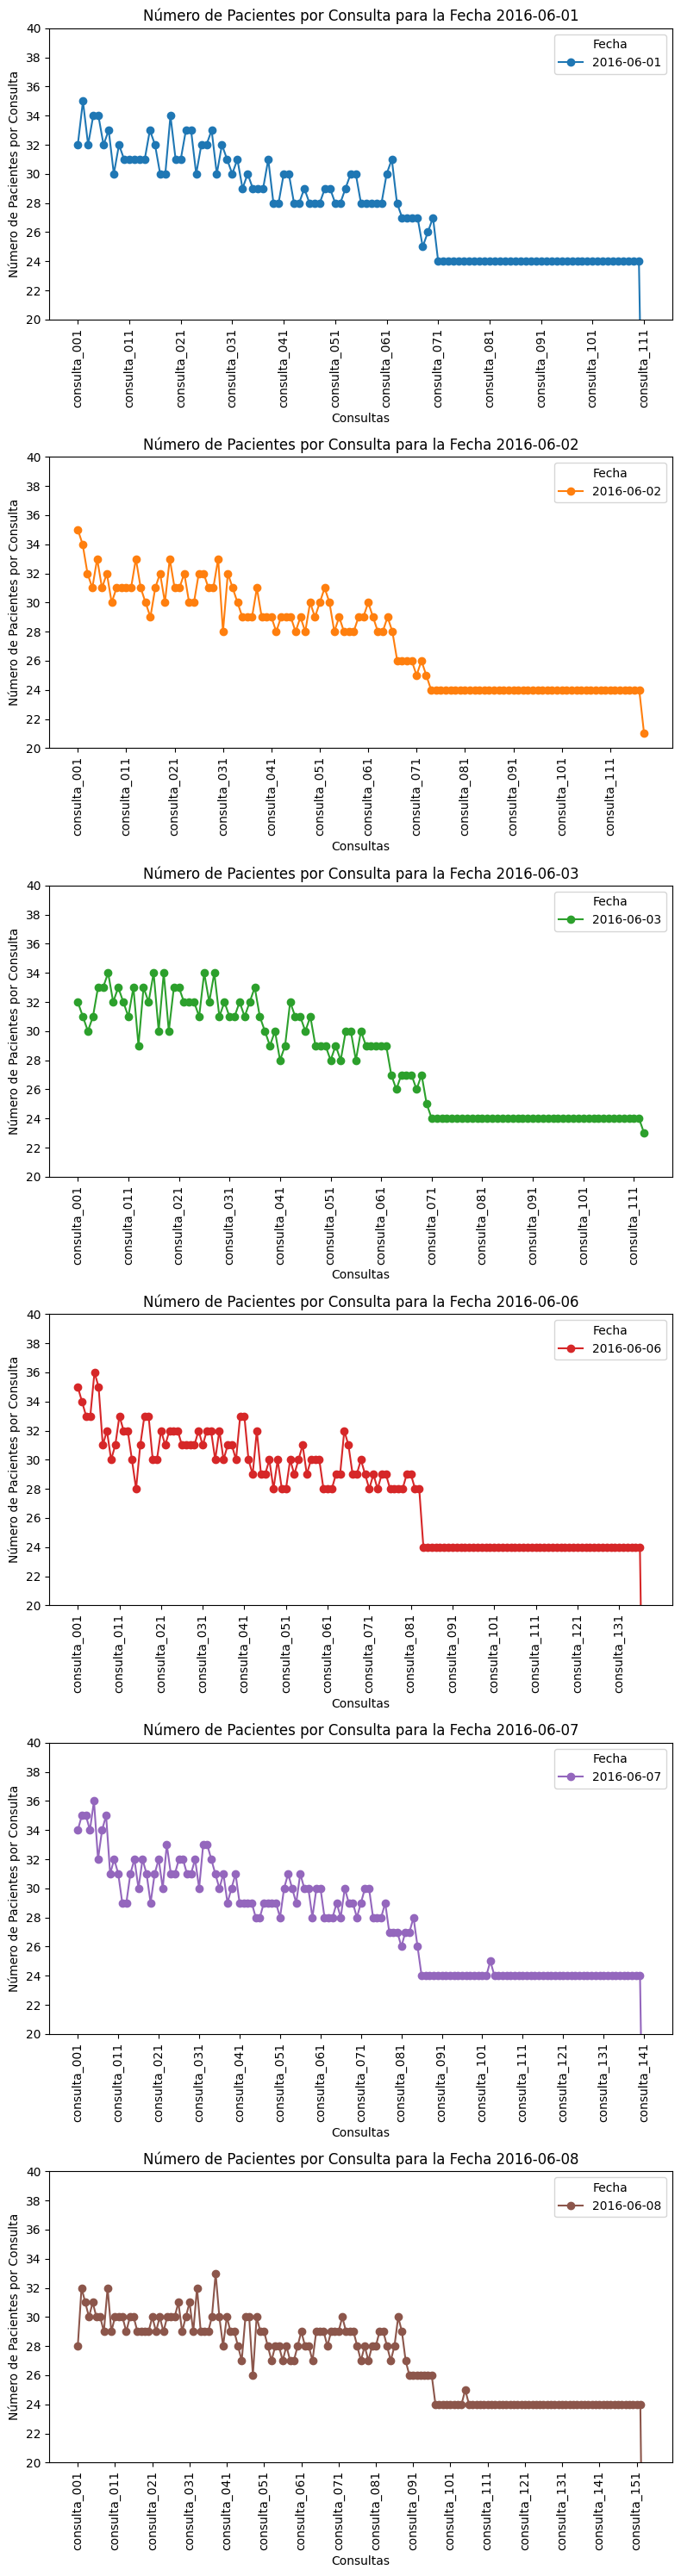


Agenda Médica ProbShow_1.0_0.35_0.15:


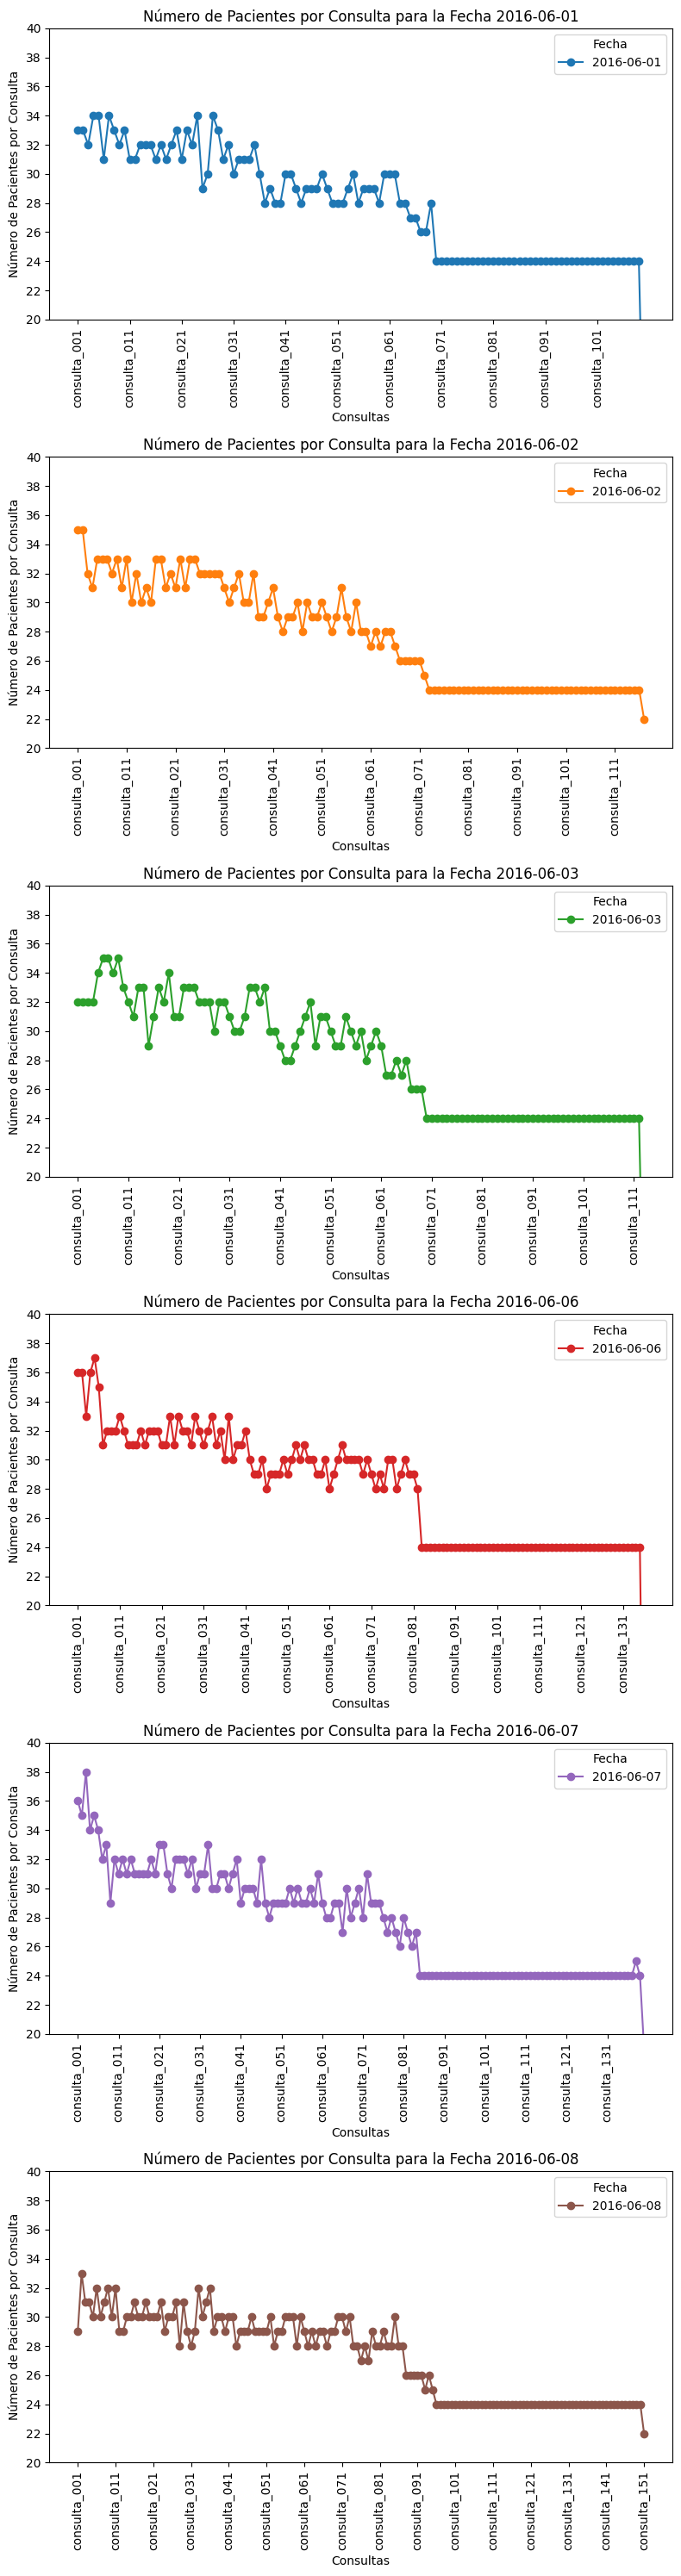


Agenda Médica ProbShow_1.0_0.3_0.2:


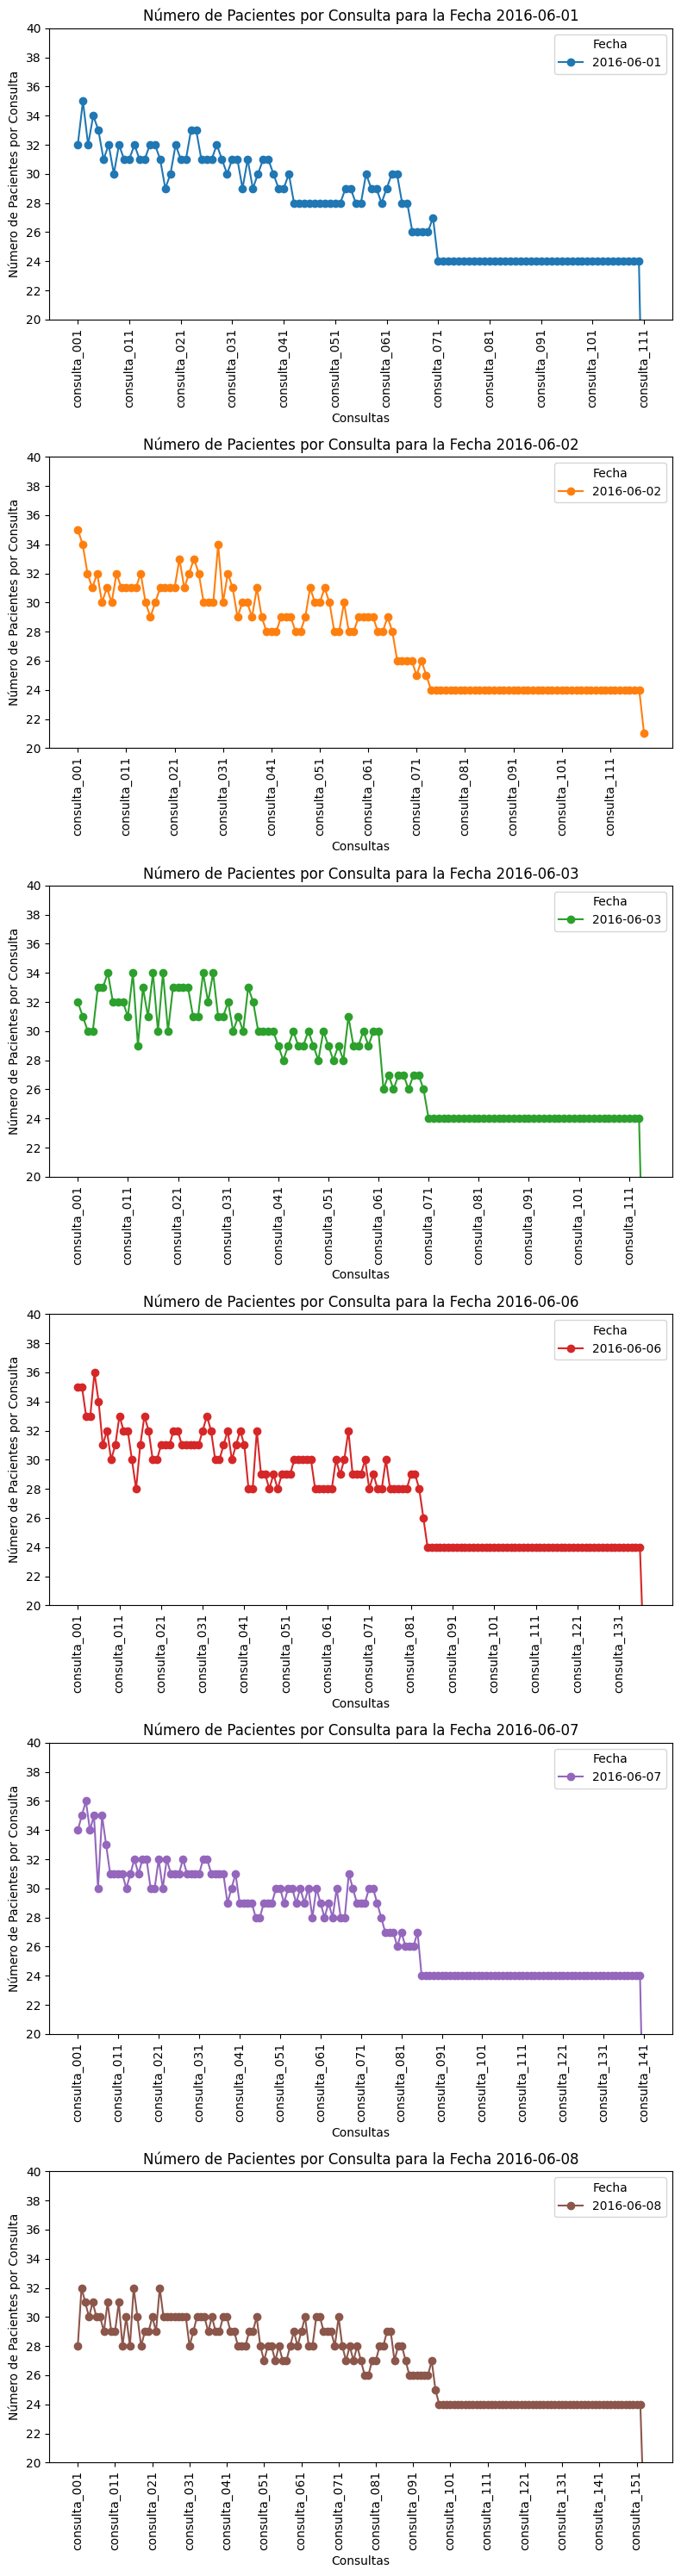


Agenda Médica ProbShow_1.0_0.35_0.2:


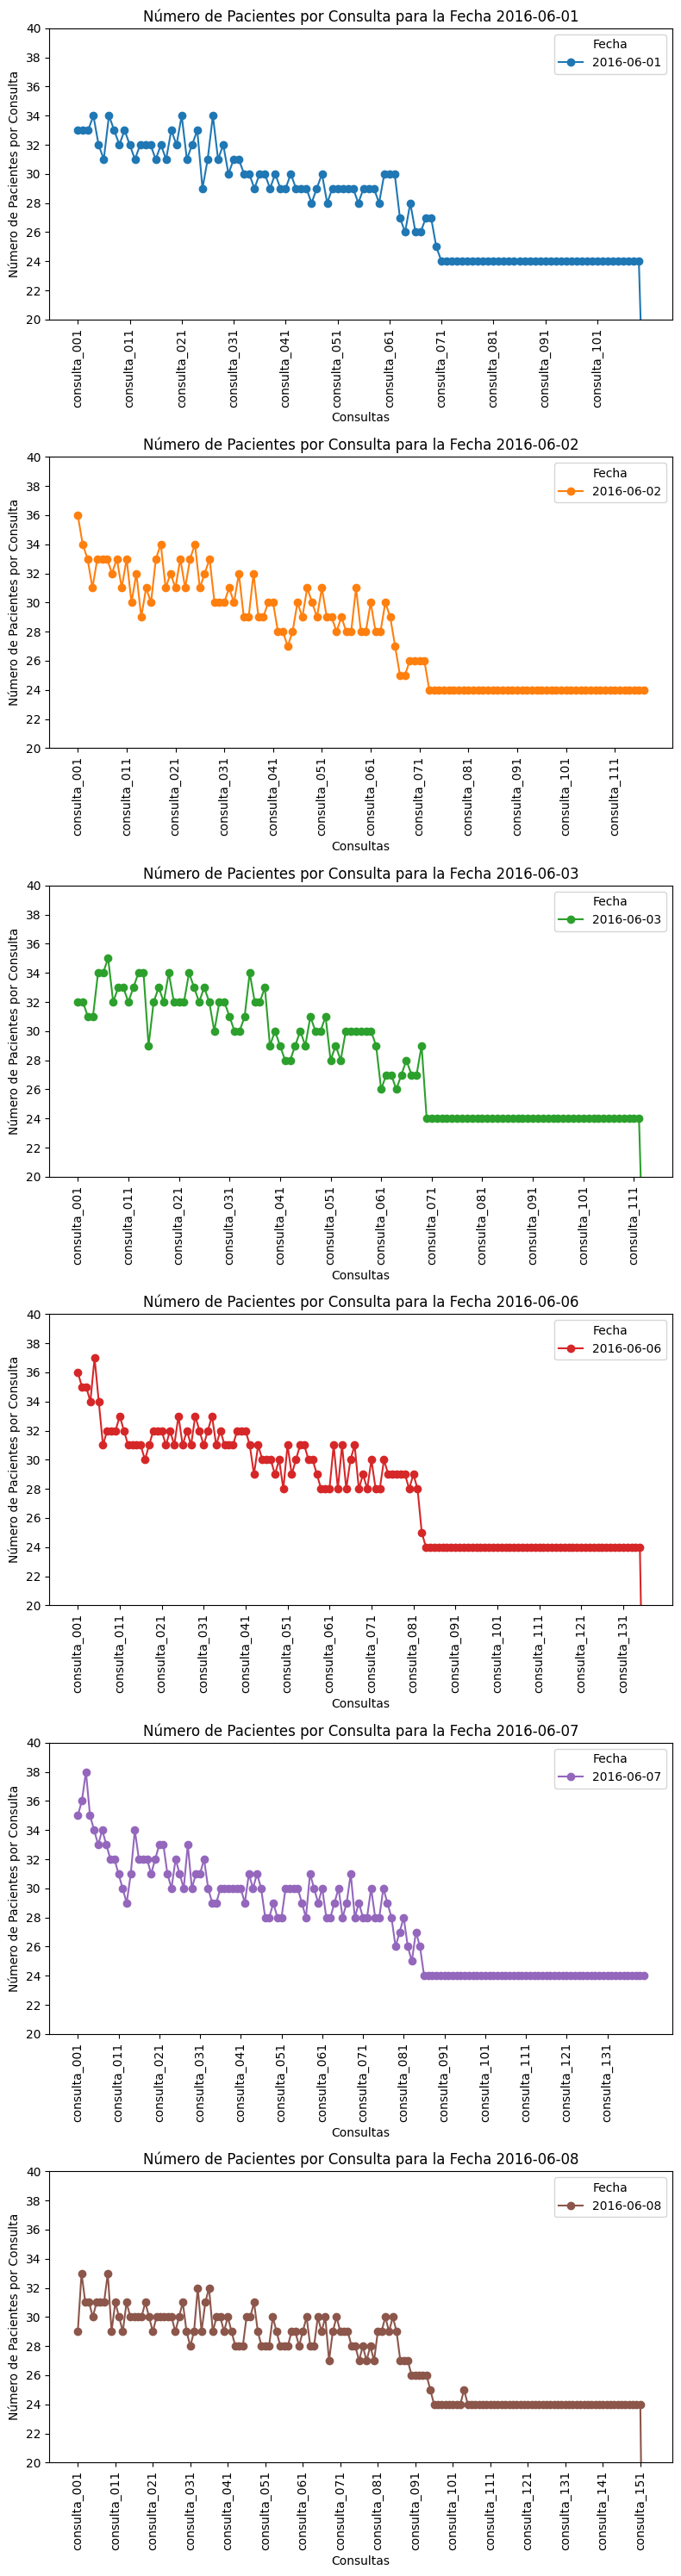


Agenda Médica ProbShow_1.05_0.3_0.15:


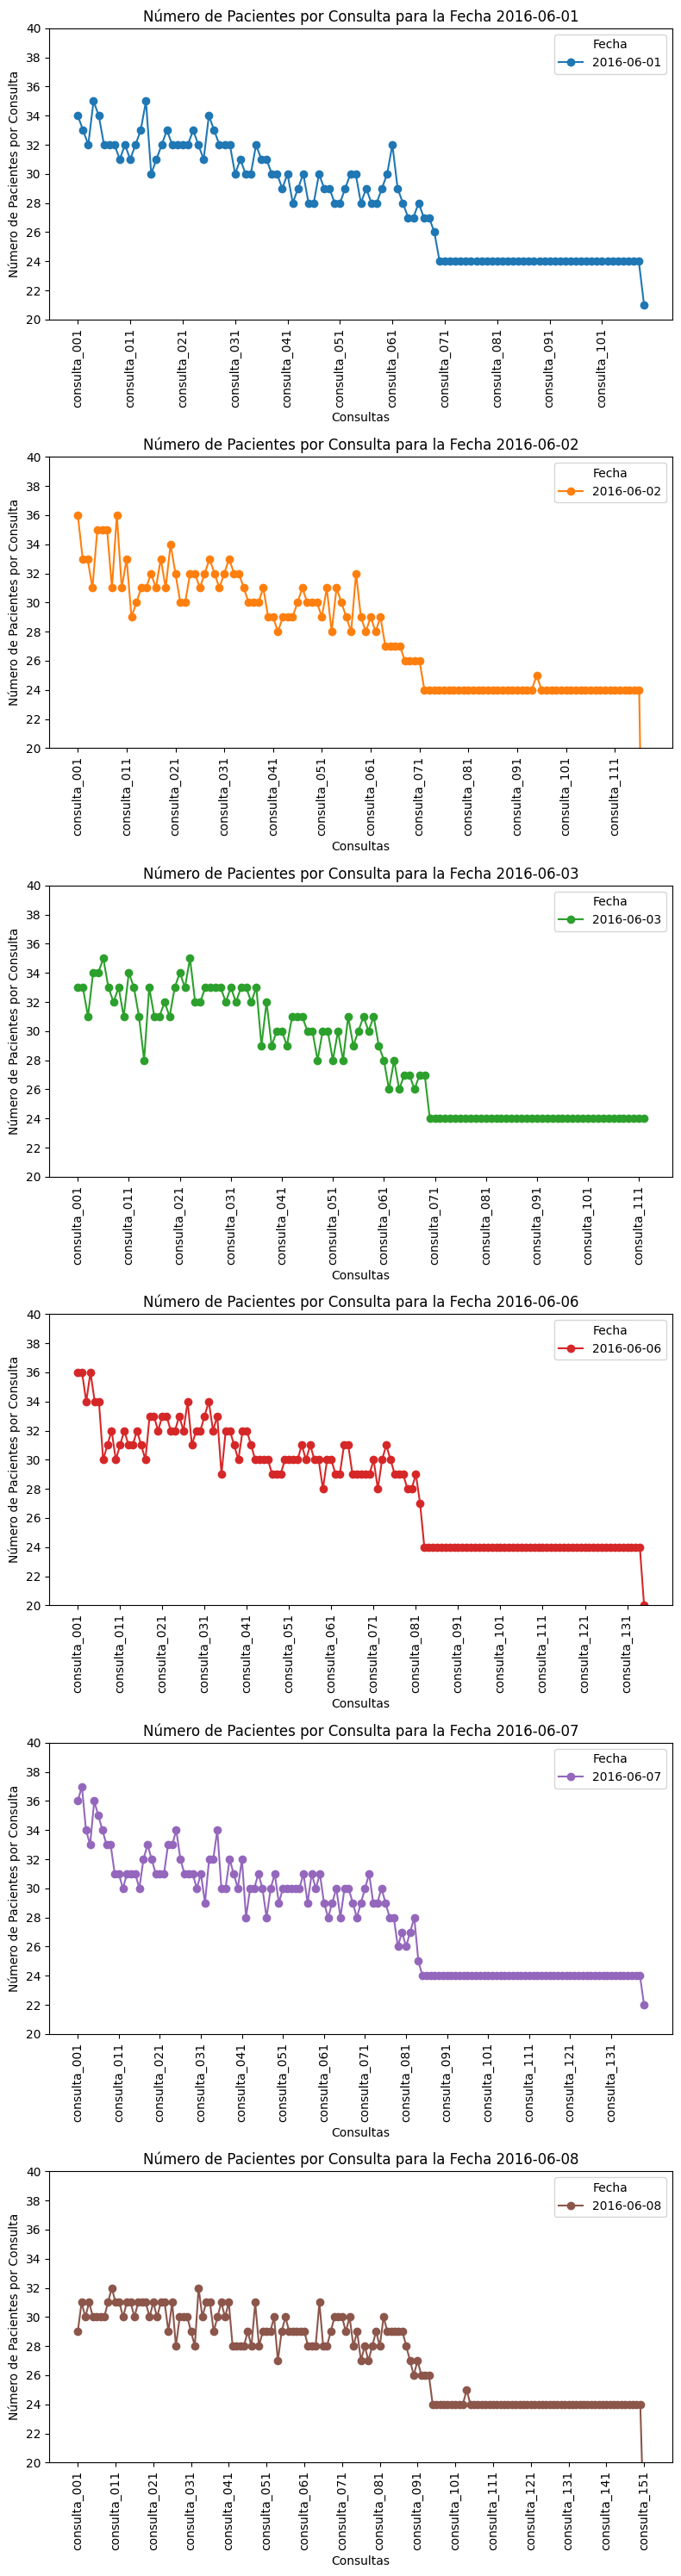


Agenda Médica ProbShow_1.05_0.35_0.15:


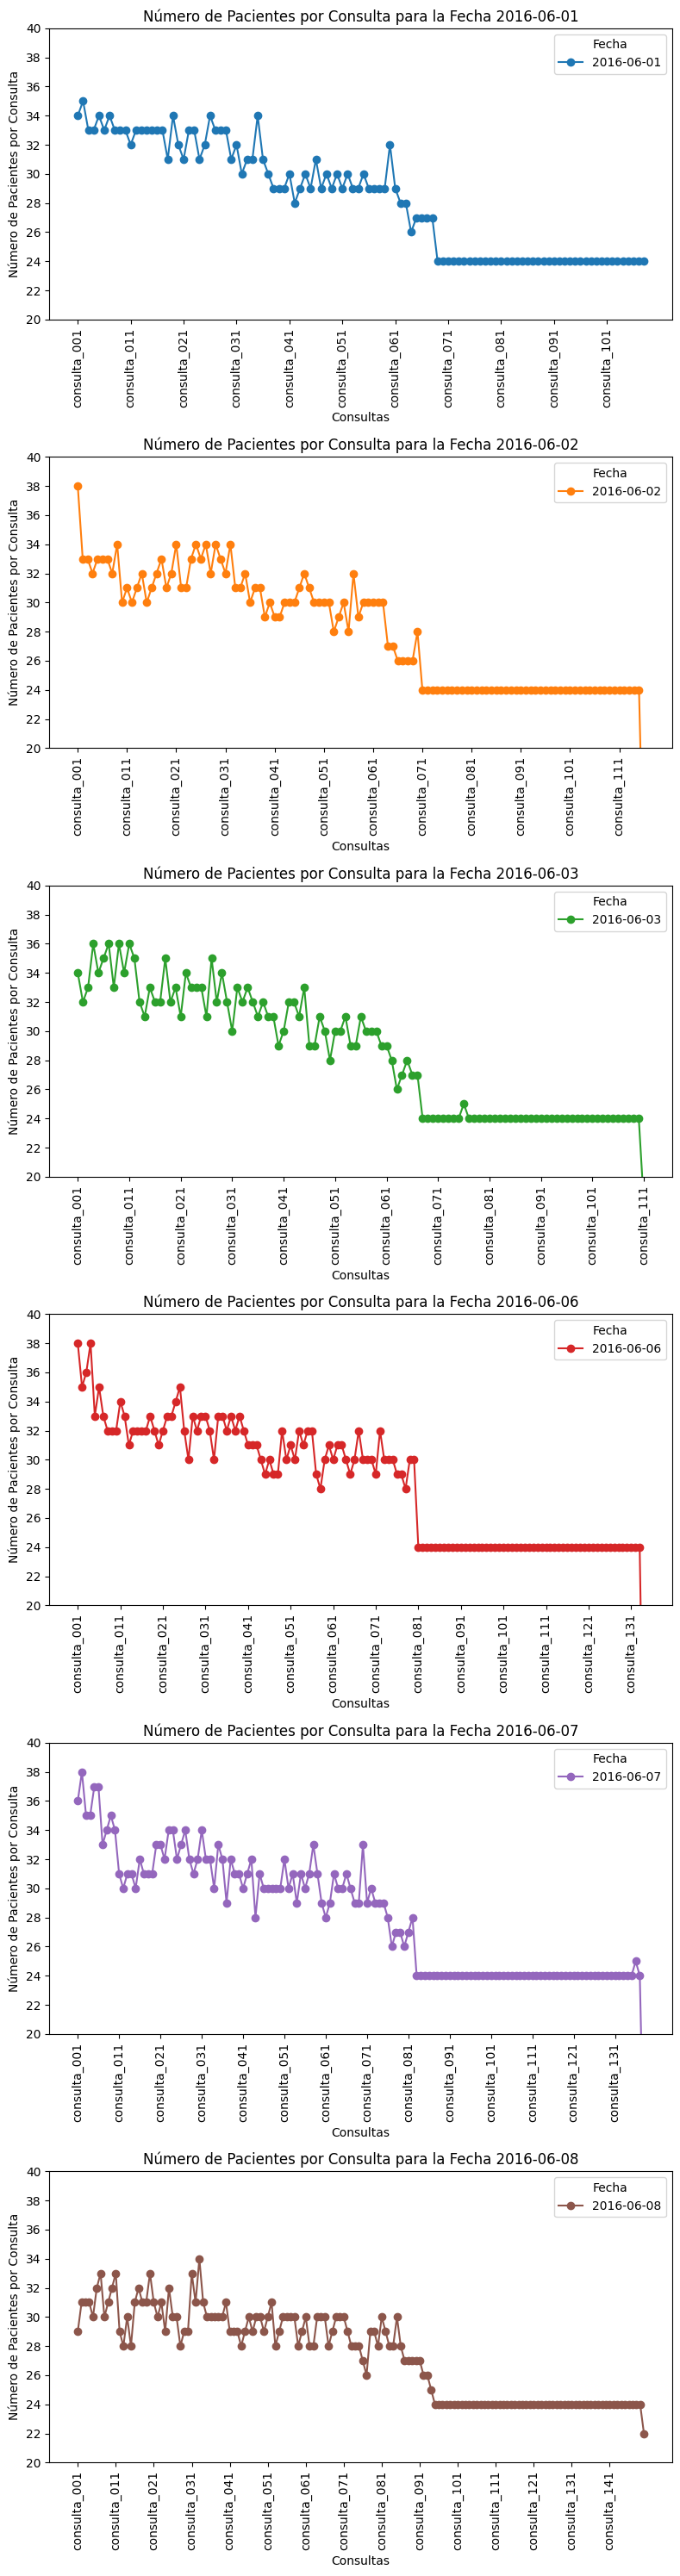


Agenda Médica ProbShow_1.05_0.4_0.15:


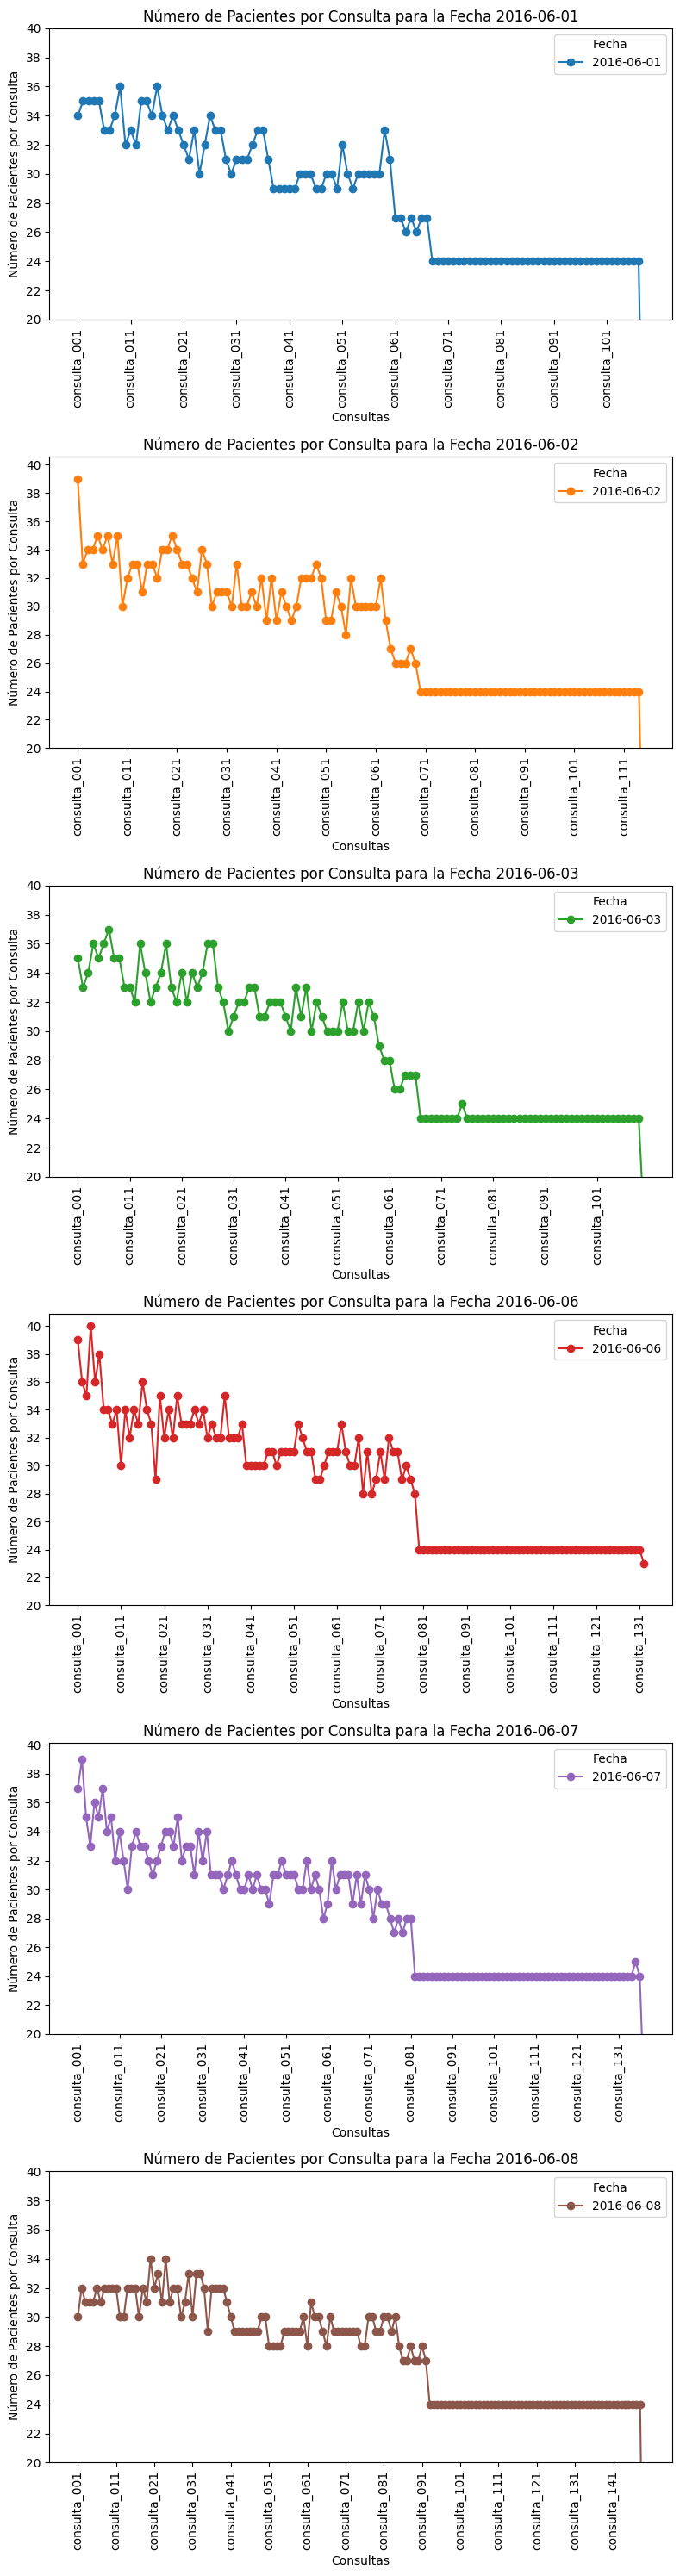


Agenda Médica ProbShow_1.05_0.45_0.15:


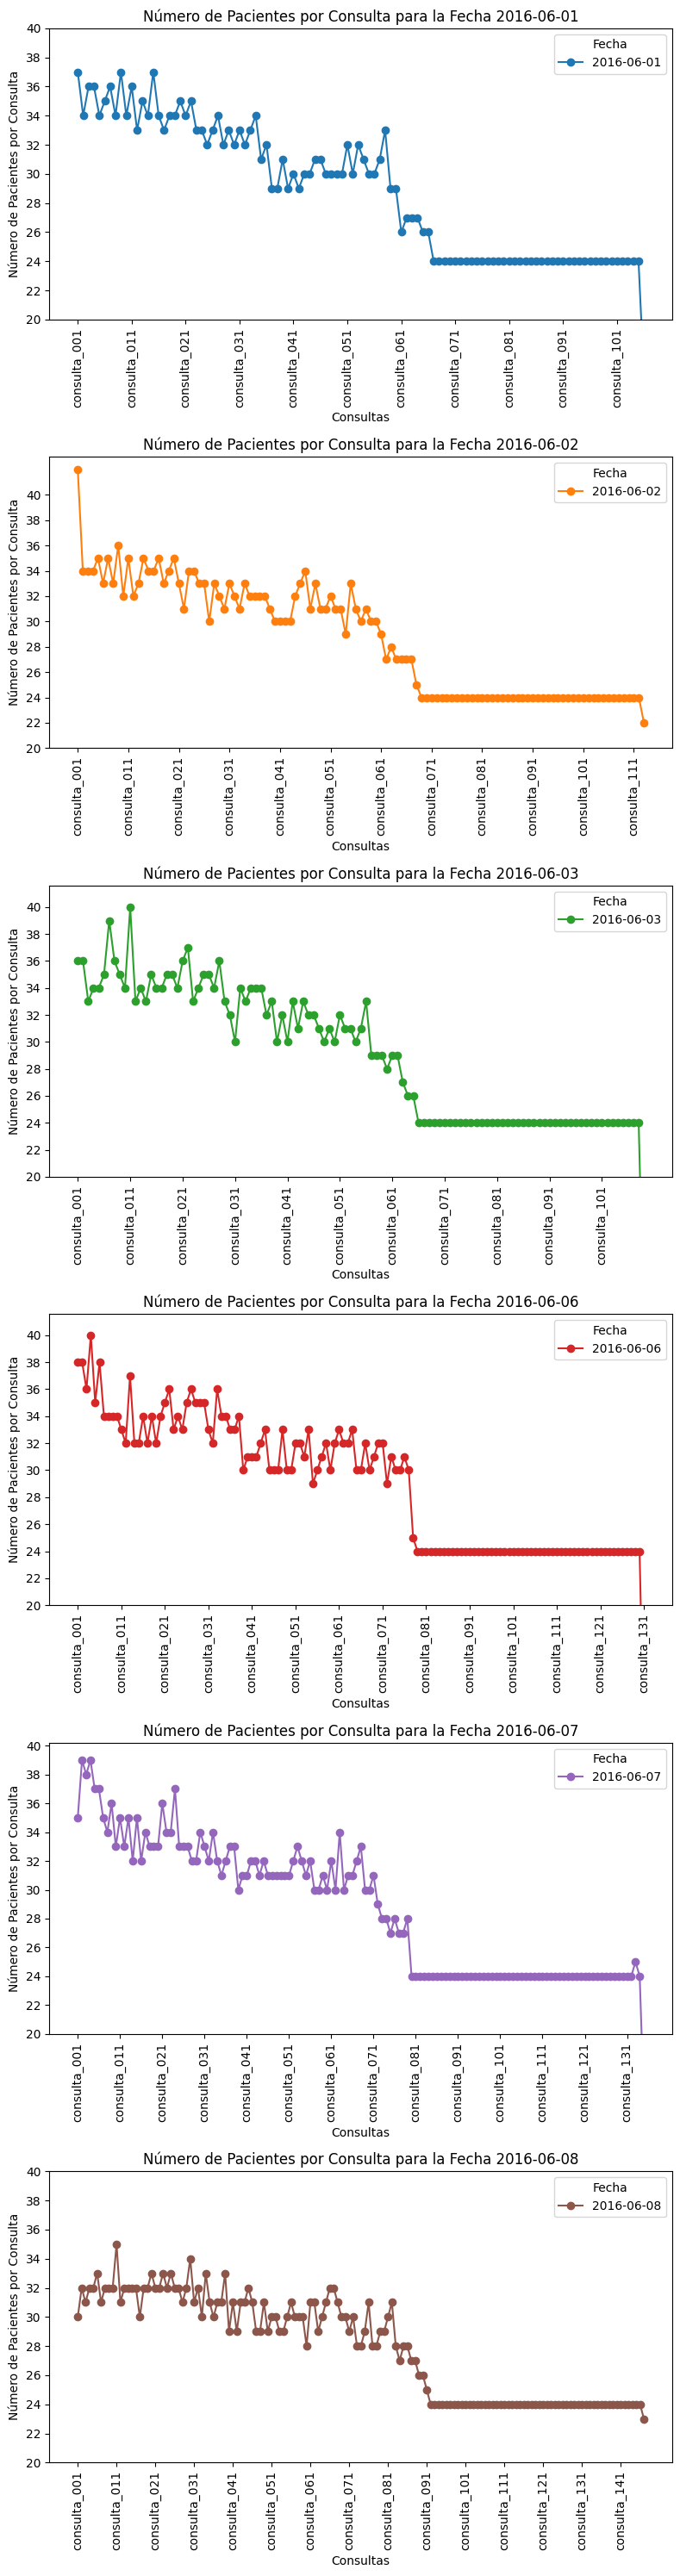


Agenda Médica ProbShow_1.1_0.25_0.15:


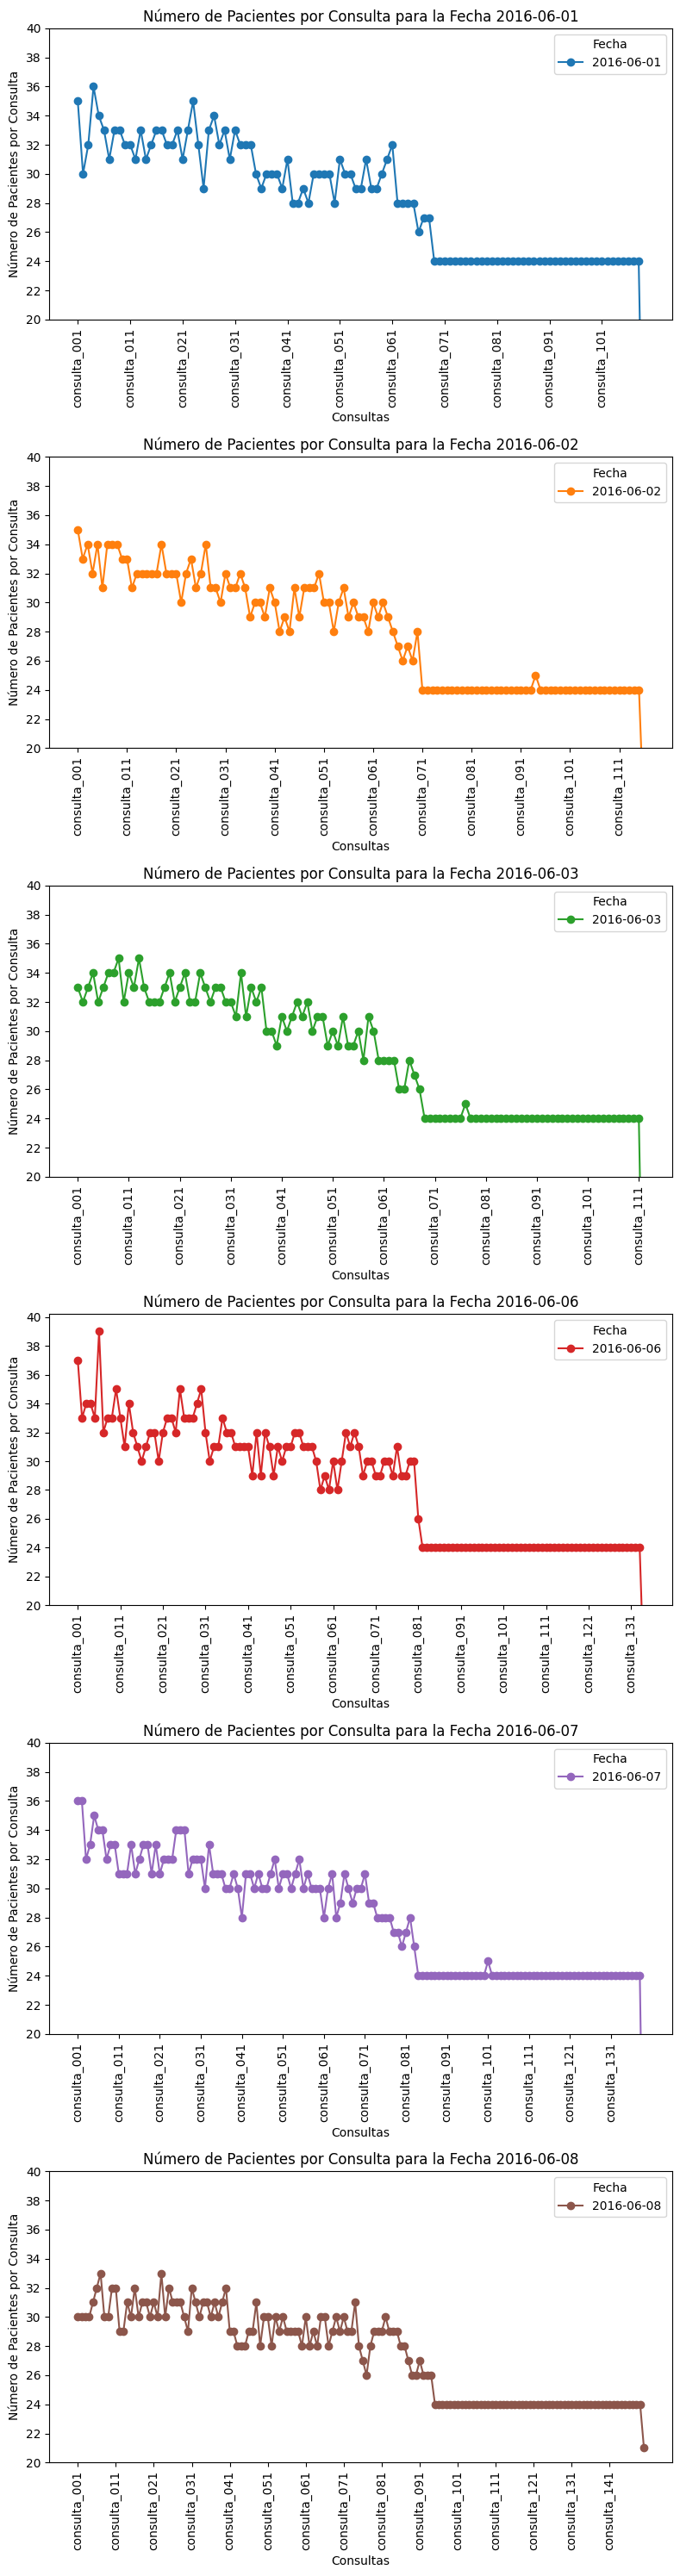


Agenda Médica ProbShow_1.1_0.3_0.15:


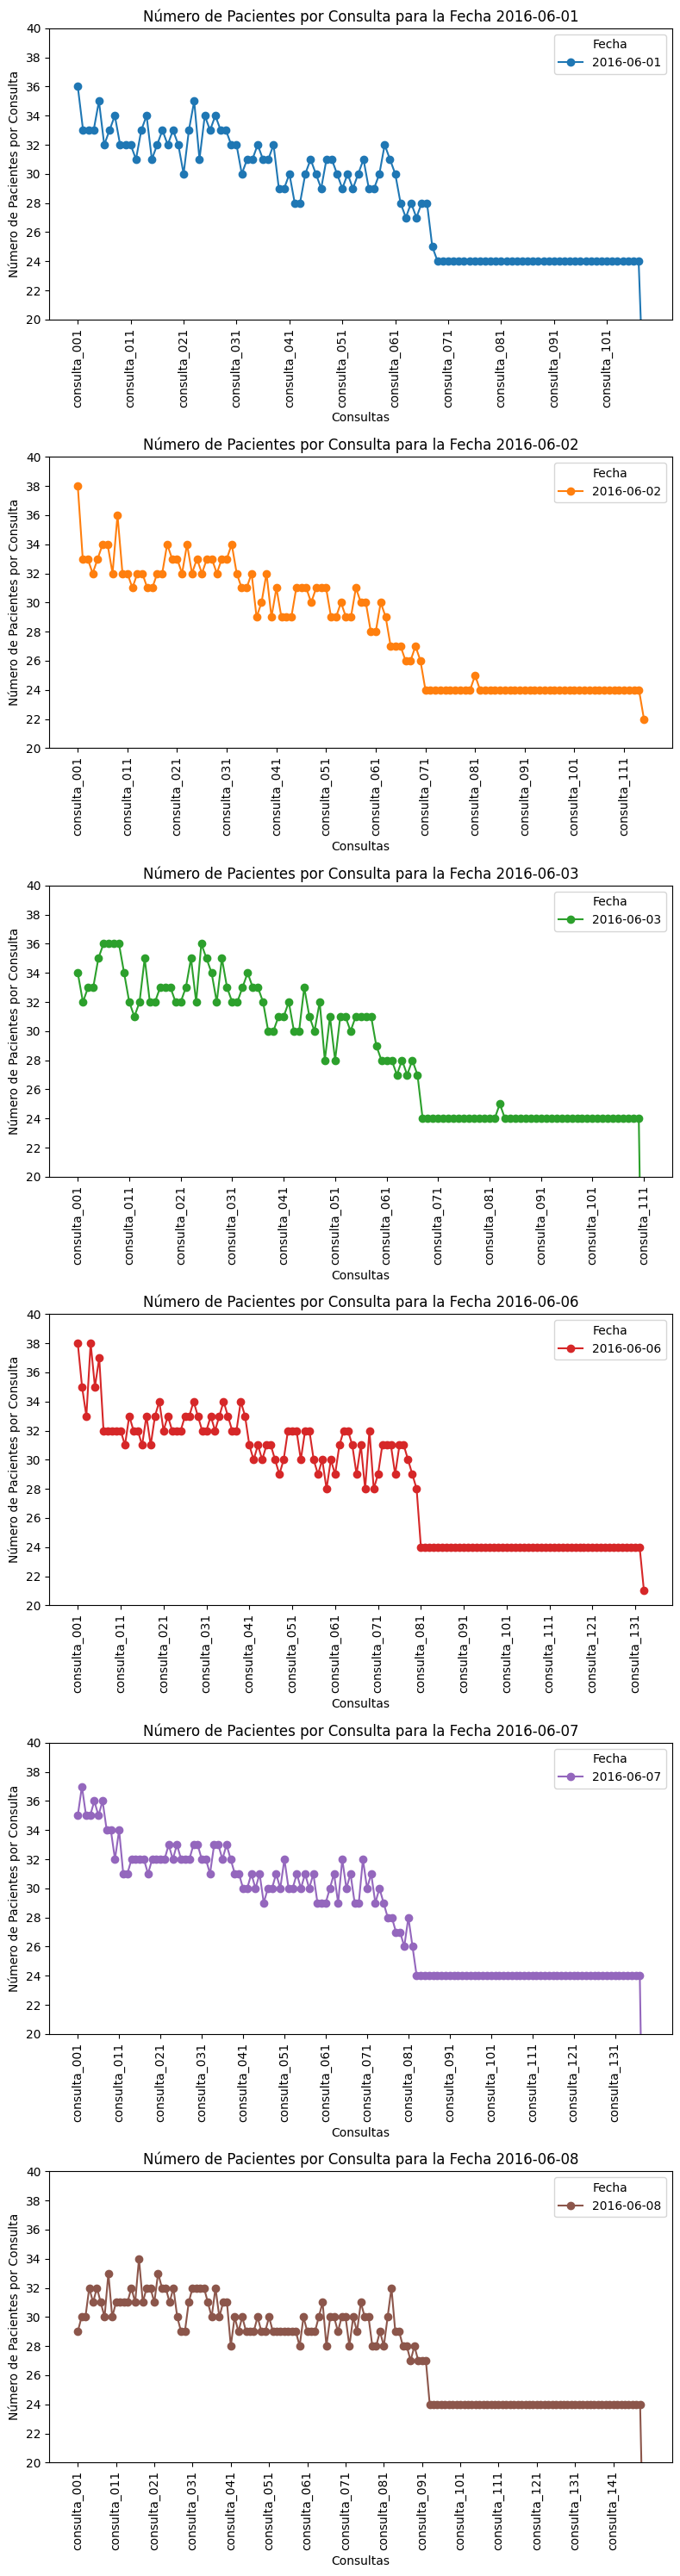


Agenda Médica ProbShow_1.1_0.35_0.15:


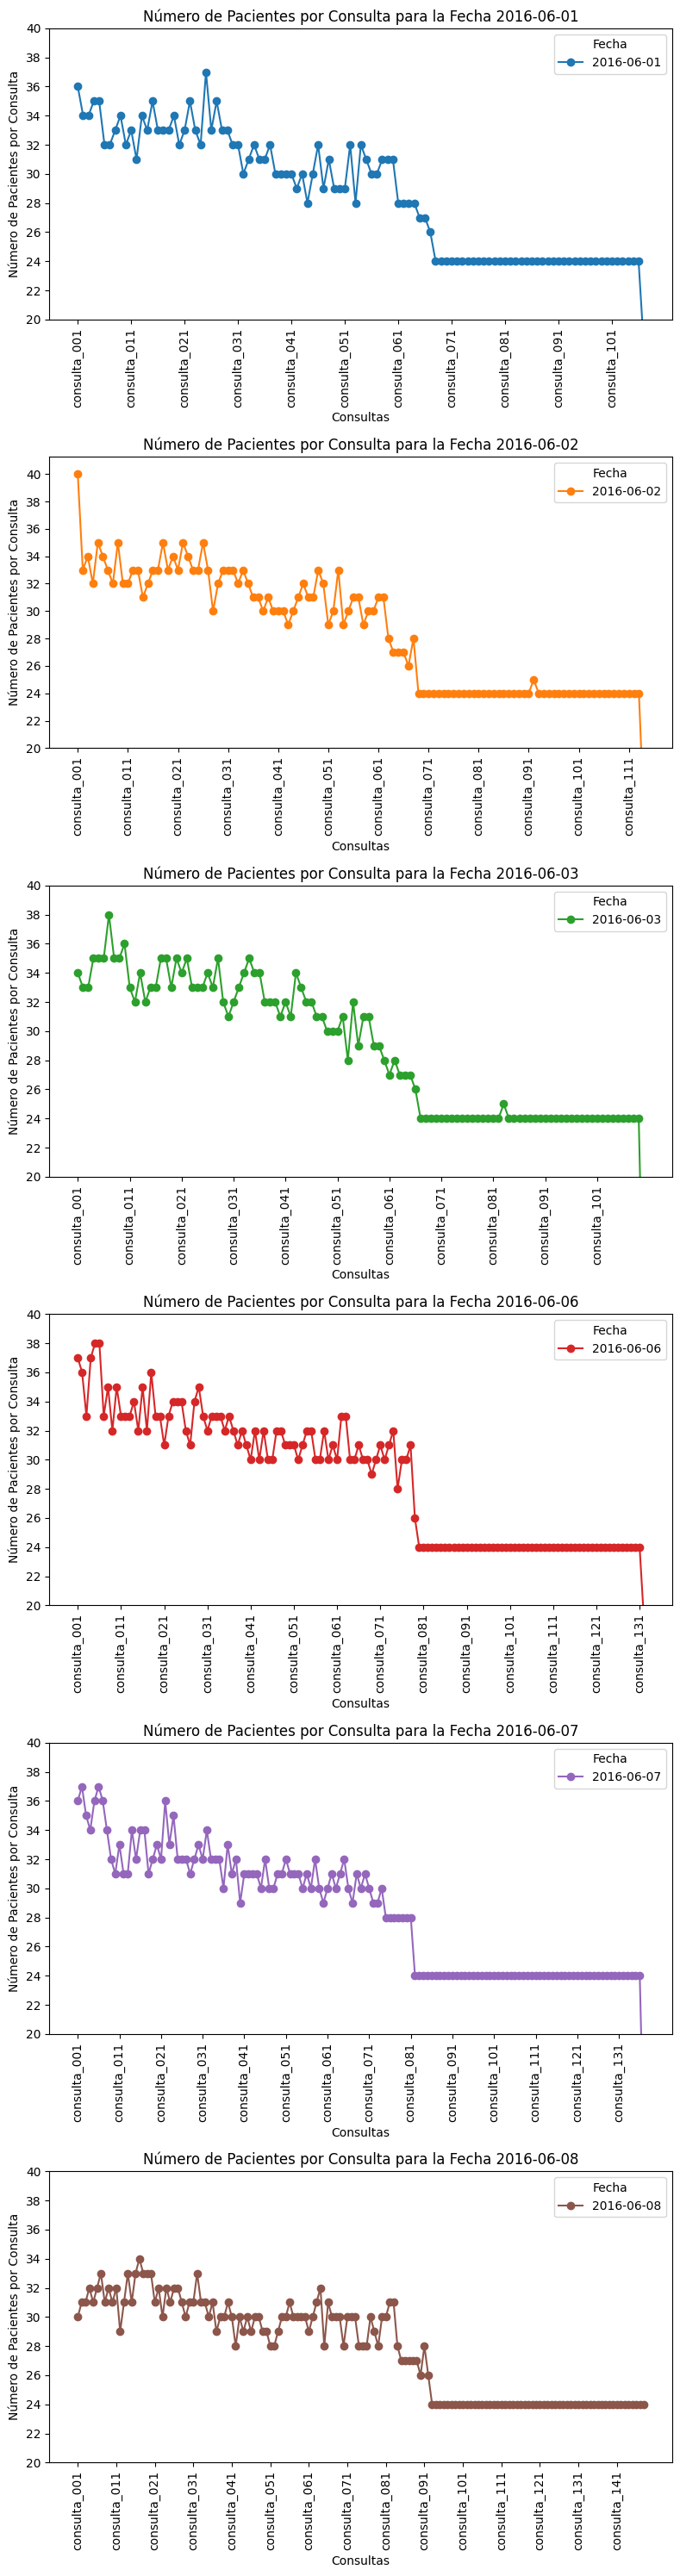


Agenda Médica ProbShow_1.1_0.4_0.15:


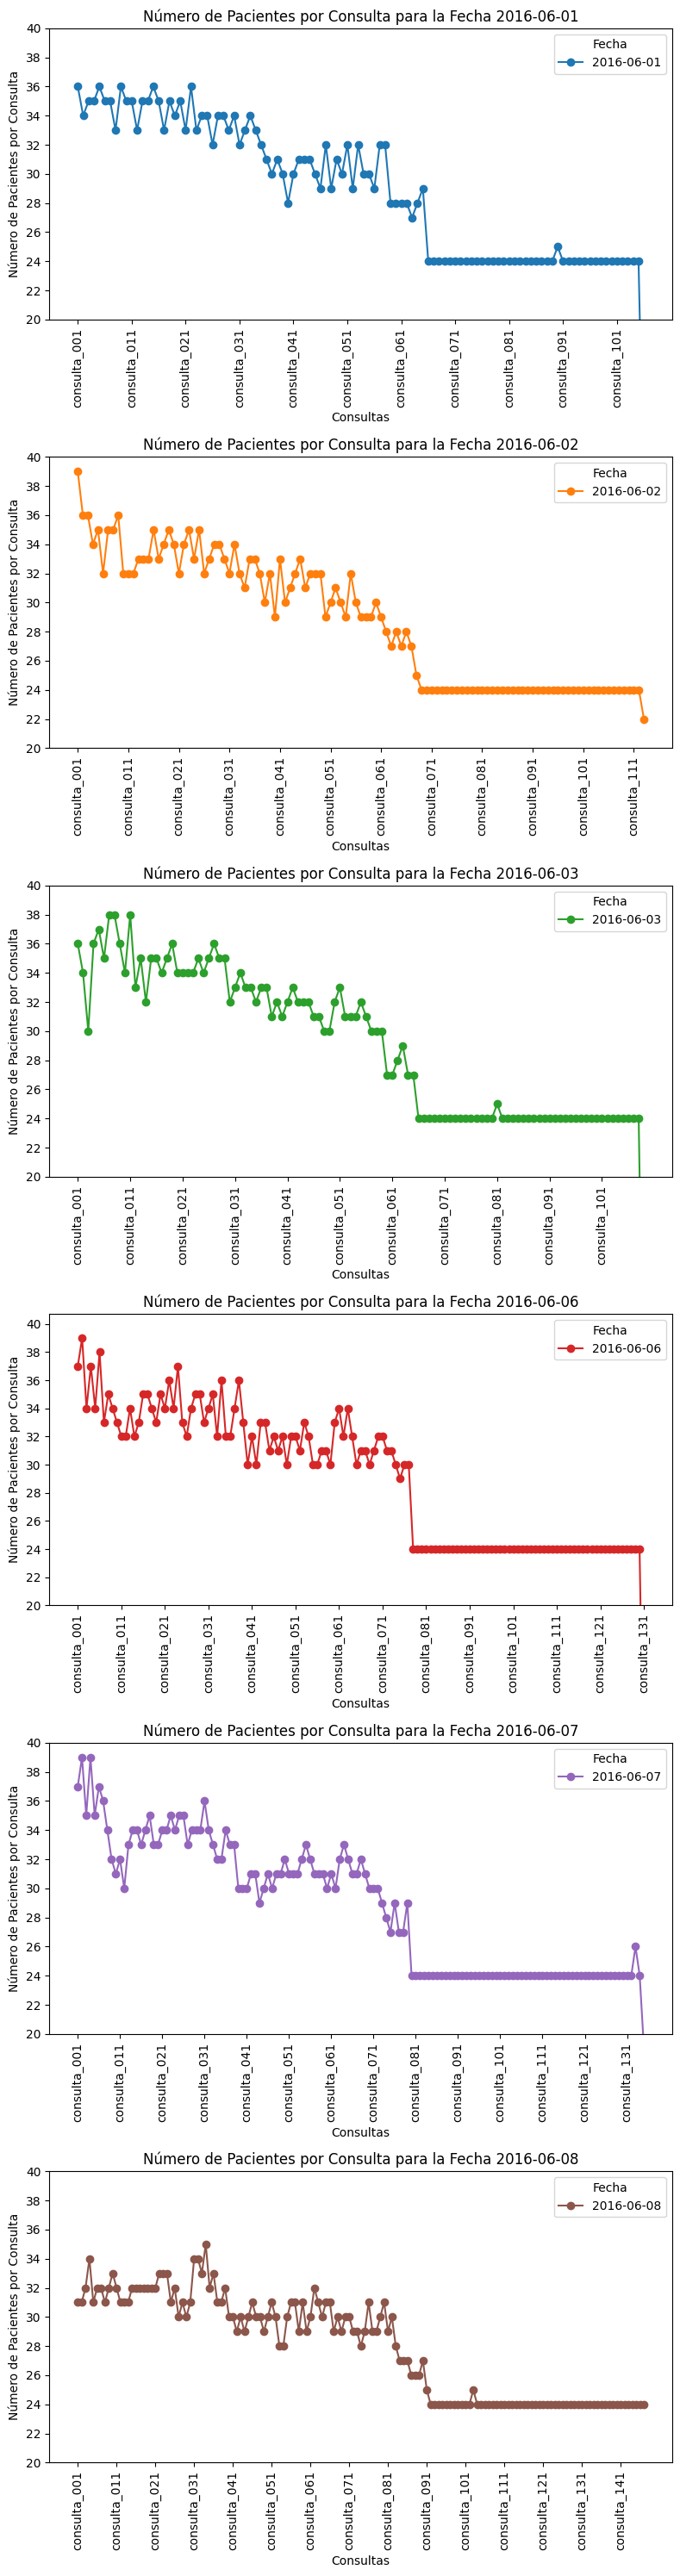

In [19]:
for agenda in dfs_pacientes_por_consulta.keys():
    print(f'\nAgenda Médica {agenda}:')
    graficar_num_pacientes_por_consulta(dfs_pacientes_por_consulta[agenda])

Agenda Médica ProbShow_0.65_0.1:


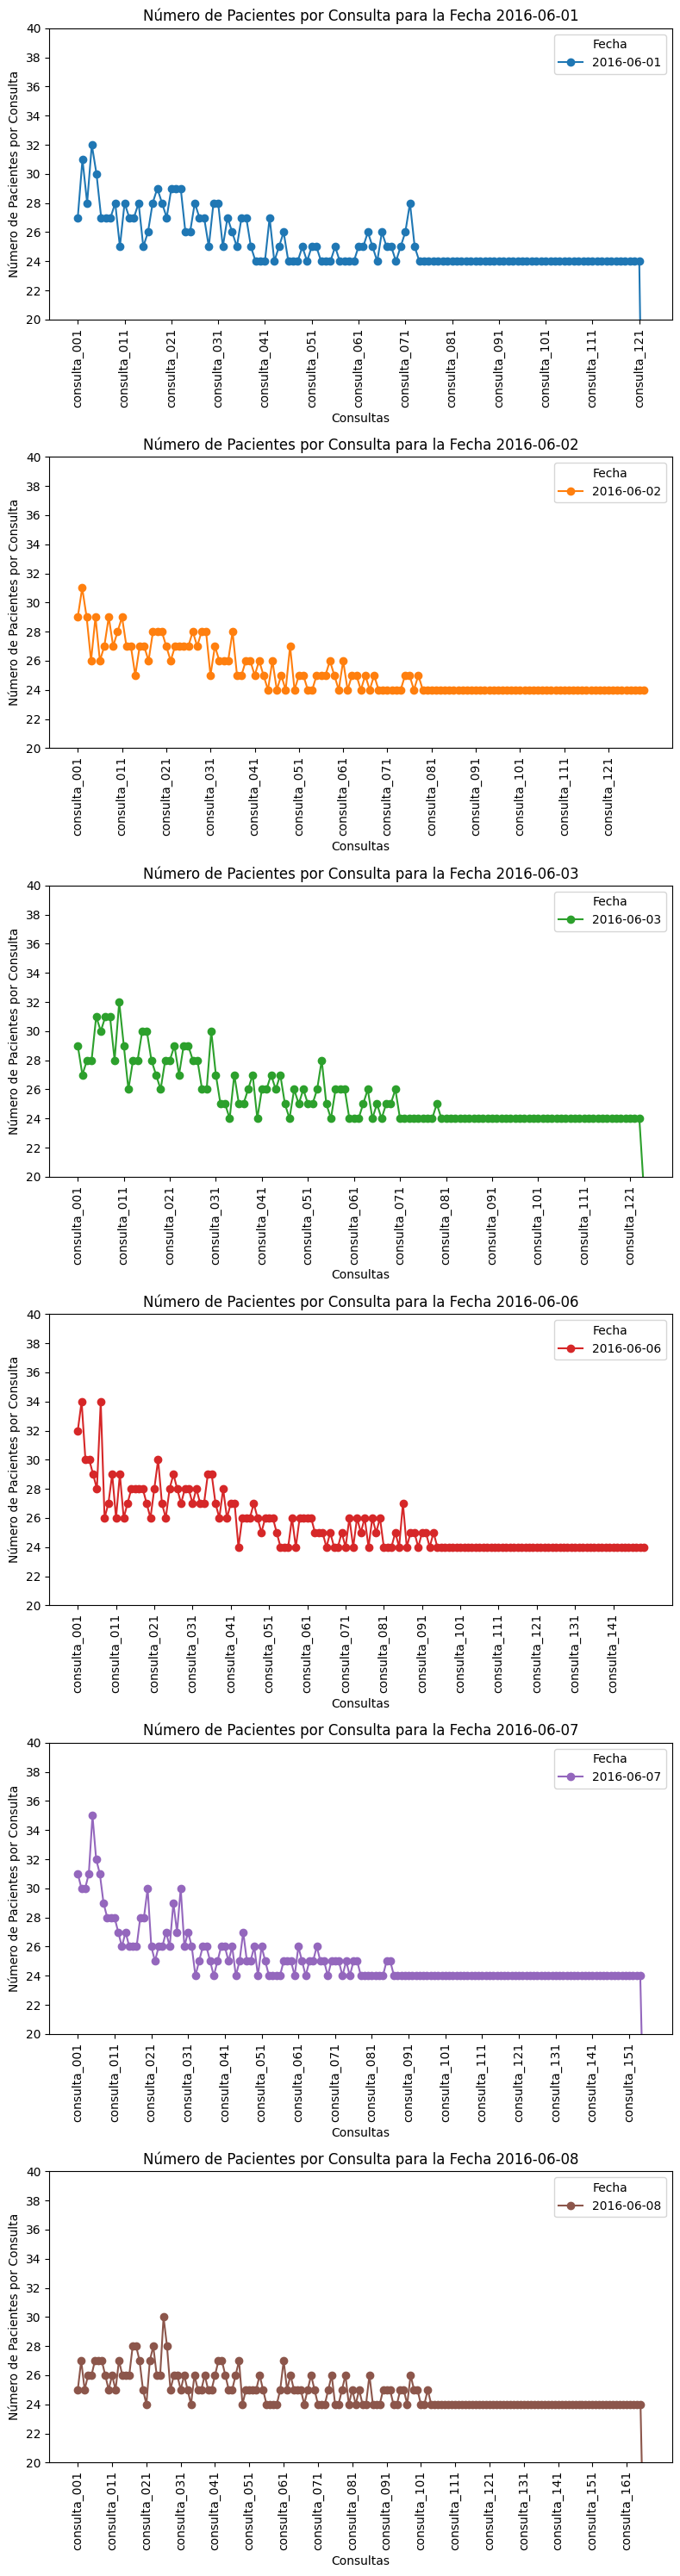

In [20]:
agenda = list(dfs_pacientes_por_consulta.keys())[1]
print(f'Agenda Médica {agenda}:')
graficar_num_pacientes_por_consulta(dfs_pacientes_por_consulta[agenda])

### 2.2 Cálculo de Costes: Idle Time, Waiting Time y Over Time

In [20]:
def convertir_a_dict (df_agenda_medica: pd.DataFrame) -> dict:
    '''
    Convierte un DataFrame de agenda médica a un diccionario con una estructura específica.
    La estructura del diccionario resultante es la siguiente:
    {
        'Fecha': {
            'Consulta': {
                'Slot': [Paciente_IDs]
            }
        }
    }

    Args:
        df_agenda_medica (pd.DataFrame): DataFrame que contiene la agenda médica con las columnas 'Fecha', 
                                        'Consulta', 'Slot' y 'Paciente_ID'.
    Returns:
        dict: Diccionario con la estructura de agenda médica organizada por fecha, consulta y slot, 
                con listas de IDs de pacientes.
    '''
    dict_agenda_medica = {}

    for _, row in df_agenda_medica.iterrows():
        fecha = row['Fecha']
        consulta = row['Consulta']
        slot = row['Slot']
        paciente_id = row['Paciente_ID']
        
        if fecha not in dict_agenda_medica:
            dict_agenda_medica[fecha] = {}
        if consulta not in dict_agenda_medica[fecha]:
            dict_agenda_medica[fecha][consulta] = {}
        if slot not in dict_agenda_medica[fecha][consulta]:
            dict_agenda_medica[fecha][consulta][slot] = []
            
        dict_agenda_medica[fecha][consulta][slot].append(paciente_id)

    return dict_agenda_medica

def calc_exp_wc(x: int) -> float:
    '''
    Calcula la diferencia del coste exponencial de la fórmula cuadrática [ ((x)^2 + (x)) / 2 ]
    para una abscisa dada y su inmediata superior.

    Args:
        indice (int): El índice actual para el cual se quiere calcular el coste exponencial.
    Returns:
        float: El coste exponencial entre dos abscisas consecutivas.
    '''
    y_sup = ((x+1)**2 + (x+1)) / 2
    y_inf = ((x)**2 + (x)) / 2
    coste_exp = y_sup - y_inf
    return coste_exp

def calculo_costes(dataset:pd.DataFrame,
                    df_agenda_medica:pd.DataFrame,
                    idle_minute_cost: float,
                    waiting_minute_cost: float,
                    overtime_minute_cost: float) -> list:
    '''
    Calcula los costos de inactividad, espera y tiempo extra basados en la agenda médica y
    los datos de asistencia de los pacientes.

    Parameters:
    ----------
    dataset : pd.DataFrame
        DataFrame que contiene información sobre los pacientes y sus citas.
        Debe tener una columna 'PatientId' y otra de 'NoShow'.
    df_agenda_medica : pd.DataFrame
        DataFrame que representa la agenda médica con los pacientes en cada slot de consulta,
        por consulta y por fecha.
    idle_minute_cost : float
        Costo por minuto de inactividad del doctor.
    waiting_minute_cost : float
        Costo por minuto de espera del paciente.
    overtime_minute_cost : float
        Costo por minuto de tiempo extra del doctor.

    Returns:
    -------
    list de diccionarios:
        - 'costs': Diccionario que contiene los costos de inactividad, espera y tiempo extra
            por fecha y consulta.
        - 'average_costs': Diccionario que contiene los costos promedio de inactividad,
            espera y tiempo extra por fecha.
    '''

    # Convertimos el DataFrame en un Diccionario
    dict_agenda_medica = convertir_a_dict(df_agenda_medica)

    idle_costs = {}   # Diccionario de Costos de inactividad del doctor
    waiting_costs = {}   # Diccionario de Costos de espera del paciente
    overtime_costs = {}   # Diccionario de Costos de tiempo extra del doctor

    for fecha_key, consultas in dict_agenda_medica.items():
        idle_costs[fecha_key] = {}
        waiting_costs[fecha_key] = {}
        overtime_costs[fecha_key] = {}
        patients_waiting[fecha_key] = {}
        min_consulta = round(len(consultas) * 0.1)   # Descartamos el 10% de las primeras consultas
        max_consulta = round(len(consultas) * 0.5)   # Descartamos el 50% de las últimas consultas

        for consulta_idx, (consulta_key, slots) in enumerate(consultas.items()):
            # Recorremos el bucle sólo para consultas indicadas
            if min_consulta <= consulta_idx <= max_consulta:
                print(f'{fecha_key} {consulta_key}:')
                # Parámetros iniciales
                idle_cost_name = f'Idle Cost {consulta_key}'
                waiting_cost_name = f'Waiting Cost {consulta_key}'
                overtime_cost_name = f'Overtime Cost {consulta_key}'

                idle_costs[fecha_key][idle_cost_name] = 24   # Coste máximo, no se ha pasado ninguna consulta.
                ### print(f'\nIdle Cost [{fecha_key} {consulta_key}] -> {idle_costs[fecha_key][idle_cost_name]}')
                waiting_costs[fecha_key][waiting_cost_name] = 0   # Coste mínimo, nadie ha esperado.
                ### print(f'Waiting Cost [{fecha_key} {consulta_key}] -> {waiting_costs[fecha_key][waiting_cost_name]}')
                overtime_costs[fecha_key][overtime_cost_name] = 0   # Coste mínimo, sin trabajo extra.
                ### print(f'Overtime Cost [{fecha_key} {consulta_key}] -> {overtime_costs[fecha_key][overtime_cost_name]}\n')

                patients_waiting_at_13 = 0   # Pacientes esperando a medio día
                patients_waiting_at_18 = 0   # Pacientes esperanto por la tarde

                for slot_idx, (slot_key, pacientes) in enumerate(slots.items(), start=1):
                    slot_ocupado = False   # Inicialmente
                    ### print(f'Slot {slot_idx}')
                    idx_insertion = 0
                    ### print(f'\tIdx_insertion = {idx_insertion}')

                    for paciente in pacientes:
                        ### print(f'\tPaciente {paciente} - Slot_ocupado = {slot_ocupado}')
                        paciente_row_index = dataset[dataset['PatientId'] == paciente].index
                        ### print(f"\t¿Faltó a la cita? {set.loc[paciente_row_index, 'NoShow'].any()}")

                        if slot_ocupado and not dataset.loc[paciente_row_index, 'NoShow'].any():
                            if slot_idx == 12:
                                if patients_waiting_at_13 >= 3:
                                    ### print(f'¡OJO! El doctor no tiene el tiempo para \
                                    ### atender a este paciente {paciente} de 13:00 a 14:00.\nSe mueve al slot de las 14:00.')
                                    waiting_costs[fecha_key][waiting_cost_name] += calc_exp_wc(patients_waiting_at_13 + idx_insertion)
                                    ### print(f'Waiting Cost [{fecha_key} {consulta_key}] -> {waiting_costs[fecha_key][waiting_cost_name]}')
                                    slot_name = f'slot_{slot_idx + 1:02d}'
                                    slots[slot_name].insert(idx_insertion, paciente)
                                    idx_insertion += 1
                                    ### print(f'\tIdx_insertion = {idx_insertion}')
                                else:
                                    overtime_costs[fecha_key][overtime_cost_name] += 1
                                    ### print(f'Overtime Cost [{fecha_key} {consulta_key}] -> {overtime_costs[fecha_key][overtime_cost_name]}')           
                                    waiting_costs[fecha_key][waiting_cost_name] += calc_exp_wc(patients_waiting_at_13)
                                    ### print(f'Waiting Cost [{fecha_key} {consulta_key}] -> {waiting_costs[fecha_key][waiting_cost_name]}')
                                    patients_waiting_at_13 += 1
                                    ### print(f'\tPatients waiting at 13:00: {patients_waiting_at_13}')
                            elif slot_idx == 24:
                                overtime_costs[fecha_key][overtime_cost_name] += 1
                                ### print(f'Overtime Cost [{fecha_key} {consulta_key}] -> {overtime_costs[fecha_key][overtime_cost_name]}')
                                waiting_costs[fecha_key][waiting_cost_name] += calc_exp_wc(patients_waiting_at_18)
                                ### print(f'Waiting Cost [{fecha_key} {consulta_key}] -> {waiting_costs[fecha_key][waiting_cost_name]}')
                                patients_waiting_at_18 += 1
                                ### print(f'\tPatients waiting at 18:00: {patients_waiting_at_18}')
                            else:
                                waiting_costs[fecha_key][waiting_cost_name] += calc_exp_wc(idx_insertion)
                                ### print(f'Waiting Cost [{fecha_key} {consulta_key}] -> {waiting_costs[fecha_key][waiting_cost_name]}')
                                slot_name = f'slot_{slot_idx + 1:02d}'
                                slots[slot_name].insert(idx_insertion, paciente)
                                idx_insertion += 1
                                ### print(f'\tIdx_insertion = {idx_insertion}')
                        elif not dataset.loc[paciente_row_index, 'NoShow'].any():
                            slot_ocupado = True
                            idle_costs[fecha_key][idle_cost_name] -= 1
                            ### print(f'Idle Cost [{fecha_key} {consulta_key}] -> {idle_costs[fecha_key][idle_cost_name]}')

                # Monetizamos costes
                duracion_slot = 20   # 20 minutos
                idle_costs[fecha_key][idle_cost_name] *= idle_minute_cost * duracion_slot
                ### print(f'\nIdle Cost [{fecha_key} {consulta_key}] -> {idle_costs[fecha_key][idle_cost_name]}')
                waiting_costs[fecha_key][waiting_cost_name] *= waiting_minute_cost * duracion_slot
                ### print(f'Waiting Cost [{fecha_key} {consulta_key}] -> {waiting_costs[fecha_key][waiting_cost_name]}')
                overtime_costs[fecha_key][overtime_cost_name] *= overtime_minute_cost * duracion_slot
                ### print(f'Overtime Cost [{fecha_key} {consulta_key}] -> {overtime_costs[fecha_key][overtime_cost_name]}\n')

    # Calculo de promedios
    def calcular_promedio(costs):
        promedio = {}
        for fecha_key, consultas_cost in costs.items():
            promedio[fecha_key] = sum(consultas_cost.values()) / (max_consulta - min_consulta + 1)
        return promedio

    average_idle_costs = calcular_promedio(idle_costs)
    df_average_idle_costs = pd.DataFrame(average_idle_costs, index=[0])
    ### print(f'La media de los Costes de Inactividad es de:')
    ### print(df_average_idle_costs,'\n')

    average_waiting_costs = calcular_promedio(waiting_costs)
    df_average_waiting_costs = pd.DataFrame(average_waiting_costs, index=[0])
    ### print(f'La media de los Costes de Espera de los Pacientes es de:')
    ### print(df_average_waiting_costs,'\n')

    average_overtime_costs = calcular_promedio(overtime_costs)
    df_average_overtime_costs = pd.DataFrame(average_overtime_costs, index=[0])
    ### print(f'La media de los Costes de Tiempo Extra de los Doctores es de:')
    ### print(df_average_overtime_costs,'\n')

    costs = {'idle_costs': idle_costs,
            'waiting_costs': waiting_costs,
            'overtime_costs': overtime_costs}
    average_costs = {'average_idle_cost': average_idle_costs,
                    'average_waiting_cost': average_waiting_costs,
                    'average_overtime_cost': average_overtime_costs}

    return costs, average_costs

In [21]:
# Función Crear una tabla DataFrame resumen con la media de los costes

def crear_tabla_resumen(costes:dict, media_costes:dict) -> pd.DataFrame:
    '''
    Crea una tabla resumen en forma de un DataFrame de pandas a partir de diccionarios de costes y medias de costes.
    Args:
        costes (dict): Un diccionario que contiene información de costes, con la siguiente estructura:
        media_costes (dict): Un diccionario que contiene las medias de distintos tipos de costes, con la siguiente estructura:
    Returns:
        pd.DataFrame: Un DataFrame de pandas con las siguientes columnas:
            - 'Fecha': Las fechas de los registros.
            - 'Consultas': El número de consultas (o registros de costes de inactividad) por fecha.
            - 'Idle Cost': El coste medio de inactividad por fecha.
            - 'Waiting Cost': El coste medio de espera por fecha.
            - 'Overtime Cost': El coste medio de horas extras por fecha.
    '''
    data = {
        'Fecha': [fecha for fecha in costes['idle_costs'].keys()],
        'Consultas': [
            len(costes['idle_costs'][fecha])
            for fecha in costes['idle_costs'].keys()
        ],
        'Idle Cost': [
            media_costes['average_idle_cost'][fecha]
            for fecha in media_costes['average_idle_cost'].keys()
        ],
        'Waiting Cost': [
            media_costes['average_waiting_cost'][fecha]
            for fecha in media_costes['average_waiting_cost'].keys()
        ],
        'Overtime Cost': [
            media_costes['average_overtime_cost'][fecha]
            for fecha in media_costes['average_overtime_cost'].keys()
        ]
    }
    return pd.DataFrame(data)

In [22]:
# Función Exportar el DataFrame a Excel

def exportar_tabla_resumen_a_excel(tabla: pd.DataFrame, regla: str) -> None:
    '''
    Exporta un DataFrame a un archivo de Excel con formato personalizado.

    La función toma un DataFrame y una cadena de texto que representa una Regla de Asignación de Cita.
    Crea un archivo de Excel con el DataFrame, añade un título basado en la regla,
    centra el texto de las celdas, aplica un formato numérico a ciertas columnas,
    ajusta el ancho de las columnas y guarda el archivo con un nombre basado en la regla.

    Parámetros:
    tabla (pd.DataFrame): El DataFrame a exportar.
    regla (str): Una cadena de texto que se utilizará para personalizar el nombre del archivo y el título de la hoja de cálculo.

    Retorno:
    None: La función no retorna ningún valor, pero guarda un archivo de Excel en el directorio actual.
    '''
    # Crear un nuevo workbook
    wb = Workbook()
    ws = wb.active

    # Añadir el título
    ws.merge_cells('A1:E1')
    nombre_tabla = 'Costes Promedio Hipótesis ' + regla
    ws['A1'] = nombre_tabla
    ws['A1'].alignment = Alignment(horizontal = 'center')

    # Añadir el DataFrame a la hoja de cálculo
    for r_idx, row in enumerate(dataframe_to_rows(tabla, index = False, header = True), 2):
        for c_idx, value in enumerate(row, 1):
            cell = ws.cell(row = r_idx, column = c_idx, value = value)
            cell.alignment = Alignment(horizontal='center')
            if isinstance(value, float) and c_idx > 2:
                cell.number_format = '0.00'

    # Ajustar el ancho de las columnas
    for col in ws.iter_cols(min_row = 2,
                            max_row = ws.max_row,
                            min_col = 1,
                            max_col = ws.max_column):
        max_length = 0
        column = col[0].column_letter
        for cell in col:
            if cell.coordinate in ws.merged_cells:  # no considerar celdas fusionadas
                continue
            try:
                if cell.value is not None and len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = (max_length + 2)
        ws.column_dimensions[column].width = adjusted_width

    # Guardar el archivo
    nombre_archivo = 'Costes_promedio_' + regla + '.xlsx'
    wb.save(nombre_archivo)

    # Mostrar mensaje de confirmación
    print(f'El DataFrame ha sido exportado exitosamente a {nombre_archivo}.')
    
    return None

In [23]:
costes = {}

for agenda_key, df_agenda_medica in dfs_agendas_medicas.items():
    print(f'\033[1mHIPÓTESIS: Regla de Asignación de Cita\n\
\tCon Probabilidades de Asistencia: {agenda_key}\033[0m\n')
    print('Set con las Citas Médicas agendadas del 1 al 8 de junio:\n')

    costes[agenda_key] = {}
    costes[agenda_key]['costes_ProbShow'] = {}
    costes[agenda_key]['media_costes_ProbShow'] = {}
    
    costes[agenda_key]['costes_ProbShow'], costes[agenda_key]['media_costes_ProbShow'] = calculo_costes(
        dataset = new_app_set,
        df_agenda_medica= df_agenda_medica,
        idle_minute_cost = 16,
        waiting_minute_cost = 0.5,
        overtime_minute_cost = 3.5
    )
    print('------------------------------------------------------------------\
-------------------------------------------------------------------------\n')

HIPÓTESIS: Regla de Asignación de Cita
	Con Probabilidades de Asistencia: agenda_medica_ProbShow_1.0_0.3_0.15

Set con las Citas Médicas agendadas del 1 al 8 de junio:

2016-06-01 consulta_012:
2016-06-01 consulta_013:
2016-06-01 consulta_014:
2016-06-01 consulta_015:
2016-06-01 consulta_016:
2016-06-01 consulta_017:
2016-06-01 consulta_018:
2016-06-01 consulta_019:
2016-06-01 consulta_020:
2016-06-01 consulta_021:
2016-06-01 consulta_022:
2016-06-01 consulta_023:
2016-06-01 consulta_024:
2016-06-01 consulta_025:
2016-06-01 consulta_026:
2016-06-01 consulta_027:
2016-06-01 consulta_028:
2016-06-01 consulta_029:
2016-06-01 consulta_030:
2016-06-01 consulta_031:
2016-06-01 consulta_032:
2016-06-01 consulta_033:
2016-06-01 consulta_034:
2016-06-01 consulta_035:
2016-06-01 consulta_036:
2016-06-01 consulta_037:
2016-06-01 consulta_038:
2016-06-01 consulta_039:
2016-06-01 consulta_040:
2016-06-01 consulta_041:
2016-06-01 consulta_042:
2016-06-01 consulta_043:
2016-06-01 consulta_044:
2016-0

In [24]:
tablas_resumen = {}
for agenda_key, costos in costes.items():
    tablas_resumen[agenda_key] = pd.DataFrame
    # Crear la Tabla RESUMEN con los costes medios para esta Regla de Asignación de Citas R11_24
    tablas_resumen[agenda_key] = crear_tabla_resumen(costos['costes_ProbShow'], costos['media_costes_ProbShow'])

    # Exportar la tabla a un fichero Excel
    exportar_tabla_resumen_a_excel(tablas_resumen[agenda_key], f'{agenda_key}')

    # Mostrar el DataFrame
    print(tablas_resumen[agenda_key],'\n')

El DataFrame ha sido exportado exitosamente a Costes_promedio_agenda_medica_ProbShow_1.0_0.3_0.15.xlsx.
        Fecha  Consultas   Idle Cost  Waiting Cost  Overtime Cost
0  2016-06-01         46  701.935484    208.064516      32.741935
1  2016-06-02         48  603.870968    240.322581      38.387097
2  2016-06-03         46  614.193548    315.645161      55.322581
3  2016-06-06         55  681.290323    274.677419      42.903226
4  2016-06-07         57  691.612903    295.645161      48.548387
5  2016-06-08         62  851.612903    238.225806      41.774194 

El DataFrame ha sido exportado exitosamente a Costes_promedio_agenda_medica_ProbShow_1.0_0.35_0.15.xlsx.
        Fecha  Consultas   Idle Cost  Waiting Cost  Overtime Cost
0  2016-06-01         45  670.967742    230.967742      39.516129
1  2016-06-02         47  516.129032    255.967742      42.903226
2  2016-06-03         46  598.709677    275.806452      53.064516
3  2016-06-06         55  624.516129    288.387097      41.7741